## Final project of Data Science

### Chia-Chun Chao

### 1\. Process the original parking violations data
Simplified datasets, where only attributes that may be analyzed are maintained, can reduce the processing time for future analysis. The range of the dataset in 2016 is from June, 2015 to June, 2016, so it is safer to process three datasets and only store data in 2016 to an intermediary file.

In [1]:
import os
import csv
import datetime
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

In [2]:
def simplifyViolationCSV(fileName):
    """
    Read a parking violation dataset and only write attributes that we may want to analyze to an intermediary file, 
    because the dataset is too large. Doing this can save time for each analysis.
    """
    
    intermediaryPath = "stats/" + fileName
    originalPath = "data/" + fileName
    
    #Only need to do this once, so we check if the file exists
    if not os.path.exists(intermediaryPath):

        with open(intermediaryPath, 'w', newline='') as csvOutputFile:
            fieldnames = ['Summons Number', 'Violation Time', 'Issue Date', 'Registration State']
            writer = csv.DictWriter(csvOutputFile, fieldnames=fieldnames)
            writer.writeheader()
    
            with open(originalPath, newline='') as csvInputFile:
                reader = csv.DictReader(csvInputFile)
                for row in reader:
                    writer.writerow({'Summons Number': row['Summons Number'], 
                                     'Violation Time': row['Violation Time'], 
                                     'Issue Date': row['Issue Date'],
                                     'Registration State': row['Registration State']})
    pass
                    
simplifyViolationCSV("NYC_Parking_Violations_2014.csv")
simplifyViolationCSV("NYC_Parking_Violations_2015.csv")
simplifyViolationCSV("NYC_Parking_Violations_2016.csv")
simplifyViolationCSV("NYC_Parking_Violations_2017.csv")

Only parking violations happened in the same year are to be analyzed, so store these data to a new csv file. In this way, instead of directly reading data into a list or a dictionary, it will be faster and easier for future use.

In [3]:
def violationsInYear(yearString):
    """
    Store parking violations happening in the input year to an intermidiary file.
    """
    
    outputFile = "stats/violations_"+yearString+".csv"
    inputFileList = ["stats/NYC_Parking_Violations_2014.csv",
                     "stats/NYC_Parking_Violations_2015.csv", 
                     "stats/NYC_Parking_Violations_2016.csv", 
                     "stats/NYC_Parking_Violations_2017.csv"]
    
    #Only need to do this once, so we check if the file exists
    if not os.path.exists(outputFile):
        
        with open(outputFile, 'w', newline='') as csvOutputFile:
            fieldnames = ['Summons Number', 'Violation Time', 'Issue Date', 'Registration State']
            writer = csv.DictWriter(csvOutputFile, fieldnames=fieldnames)
            writer.writeheader()
            
            #Read all datasets and only store violations happening in the input year
            for inputFile in inputFileList:
                with open(inputFile, newline='') as csvInputFile:
                    reader = csv.DictReader(csvInputFile)
                    for row in reader:
                        if row['Issue Date'][-4:] == yearString:
                            writer.writerow({'Summons Number': row['Summons Number'], 
                                             'Violation Time': row['Violation Time'], 
                                             'Issue Date': row['Issue Date'],
                                             'Registration State': row['Registration State']})
    pass

violationsInYear("2014")
violationsInYear("2015")
violationsInYear("2016")
violationsInYear("2017")

Read violations happening in 2016 and store data in a dictionary. Summons Number is unique, so the key of the dictionary is set to be summons number.

In [4]:
#Read data in 2016 to a dictionary mapping summons number to violation information
def readViolationinYear(yearString):
    with open("stats/violations_"+yearString+".csv", newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        violationDictYear = {}
        for row in reader:
            violationInfoDictYear = {}
            if row['Summons Number'] in violationDictYear:
                print("Duplicate summons number: ", end='')
                print(row['Summons Number'])
            else:
                violationInfoDictYear['Violation Time'] = row['Violation Time']
                violationInfoDictYear['Issue Date'] = row['Issue Date']
                violationInfoDictYear['Registration State'] = row['Registration State']
                violationDictYear[row['Summons Number']] = violationInfoDictYear
                
    return violationDictYear

violationDict = readViolationinYear("2016")
print("The number of parking violations happening in 2016: ", end='')
print(len(violationDict))


The number of parking violations happening in 2016: 10241308


### 2\. Answer if parking violations happen more on specific days

To do this, we need to count the violations occuring on the same date. Before doing this, missing values should be checked and processed.

In [5]:
def listwise_deletion(data):
    """
    Read data and perform listwise deletion (dropping any observations)
    where at least one value is missing. 
    """
    attributeList = ['Violation Time', 'Issue Date', 'Registration State']
    dictWithoutMissing = {}
    missingFlag = False
    
    for summons in data:
        for attribute in attributeList:
            #If a non-blank row has fewer fields than fieldnames when reading from csv,
            #the missing values are filled-in with None or just left empty.
            if data[summons][attribute] == None or data[summons][attribute] == '':
                missingFlag = True
                #print("Summons with missing values")
                #print(summons, end=' ')
                #print(attribute)
                break
        if missingFlag == False:   
            dictWithoutMissing[summons] = data[summons]
        else:
            missingFlag = False
            
    print("After listwise deletion, the number of parking violations happening in this year: ", end='')
    print(len(dictWithoutMissing))
    
    return dictWithoutMissing

violationWithoutMissingDict = listwise_deletion(violationDict)

After listwise deletion, the number of parking violations happening in this year: 10241191


Count the number of violations occuring on the same day and show the result in a figure.

In [6]:
def storeViolationDateToList(data):
    """
    Store every violation issue date in the input dictionary to a list
    """
    violationDateList = []

    for summons in data:
        violation = data[summons]
        violationDateList.append(datetime.datetime.strptime(violation['Issue Date'], "%m/%d/%Y"))
    return violationDateList
        
violationDateList = storeViolationDateToList(violationWithoutMissingDict)

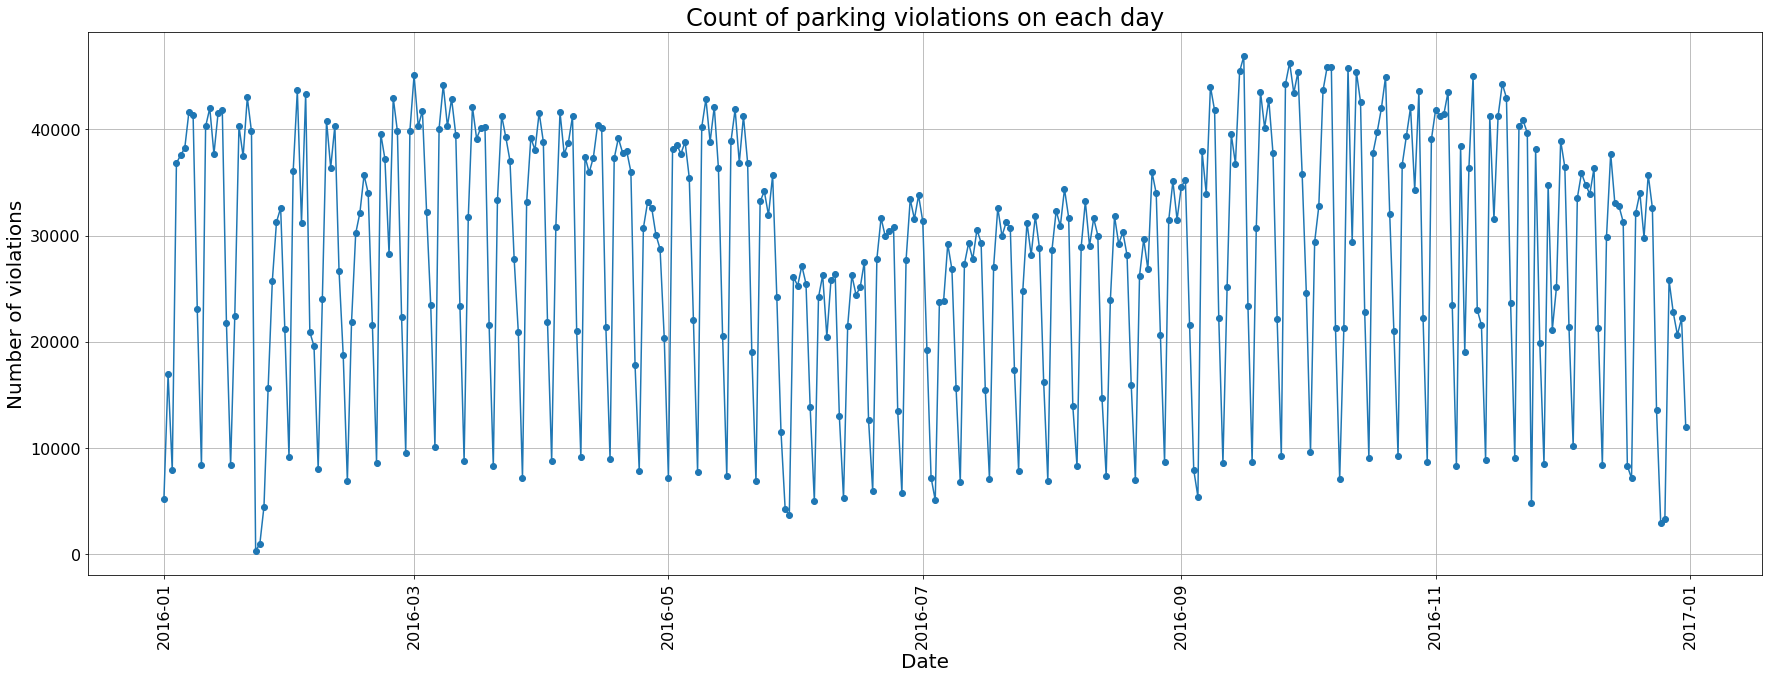

In [7]:
def plotViolationDateCount(violationDateCount):
    """
    Make a plot showing the number of violations on each day
    """
    dateList = []
    countList = []

    for key in sorted(violationDateCount):
        dateList.append(key)
        countList.append(violationDateCount[key])

    plt.figure(figsize=(30,10))
    plt.plot(dateList, countList, 'o-')
    plt.title("Count of parking violations on each day", fontsize=24)
    plt.xlabel("Date", fontsize=20)
    plt.ylabel("Number of violations", fontsize=20)
    plt.tick_params(labelsize=16)
    plt.xticks(rotation=90)
    plt.grid()
    #plt.legend(fontsize=20)
    #plt.savefig('stats/violationsOnEachDay2016.png')
    plt.show()

    pass

violationDateCount = Counter(violationDateList)
plotViolationDateCount(violationDateCount)

The numbers of parking violations in between June to August are obviously fewer than other months. The largest 50 numbers of parking violations are printed to show if there is any date in June, July, or August.

In [8]:
print("The largest 50 numbers of parking violations in the whole year")
print("==============================================================")

for key in sorted(violationDateCount.most_common()[:50]):
    print(key[0].strftime("%Y-%m-%d(%a)"), end='')
    print(": ", end='')
    print(key[1])

The largest 50 numbers of parking violations in the whole year
2016-01-07(Thu): 41656
2016-01-08(Fri): 41338
2016-01-12(Tue): 41991
2016-01-14(Thu): 41565
2016-01-15(Fri): 41847
2016-01-21(Thu): 43003
2016-02-02(Tue): 43662
2016-02-04(Thu): 43352
2016-02-25(Thu): 42977
2016-03-01(Tue): 45091
2016-03-03(Thu): 41756
2016-03-08(Tue): 44166
2016-03-10(Thu): 42882
2016-03-15(Tue): 42119
2016-03-22(Tue): 41296
2016-03-31(Thu): 41565
2016-04-05(Tue): 41634
2016-05-10(Tue): 42855
2016-05-12(Thu): 42132
2016-05-17(Tue): 41884
2016-05-19(Thu): 41257
2016-09-08(Thu): 44027
2016-09-09(Fri): 41792
2016-09-15(Thu): 45456
2016-09-16(Fri): 46869
2016-09-20(Tue): 43562
2016-09-22(Thu): 42808
2016-09-26(Mon): 44269
2016-09-27(Tue): 46280
2016-09-28(Wed): 43426
2016-09-29(Thu): 45410
2016-10-05(Wed): 43665
2016-10-06(Thu): 45874
2016-10-07(Fri): 45898
2016-10-11(Tue): 45823
2016-10-13(Thu): 45440
2016-10-14(Fri): 42597
2016-10-19(Wed): 41972
2016-10-20(Thu): 44923
2016-10-26(Wed): 42064
2016-10-28(Fri): 

The vertice with lower values seem to be in some pattern, so the smallest 30 numbers of parking violations are printed.

In [9]:
print("The fewest 30 numbers of parking violations in the whole year")
print("=============================================================")
for key in sorted(violationDateCount.most_common()[-30:]):
    print(key[0].strftime("%Y-%m-%d(%a)"), end='')
    print(": ", end='')
    print(key[1])

The fewest 30 numbers of parking violations in the whole year
2016-01-01(Fri): 5217
2016-01-23(Sat): 356
2016-01-24(Sun): 965
2016-01-25(Mon): 4502
2016-02-14(Sun): 6906
2016-03-27(Sun): 7184
2016-05-01(Sun): 7225
2016-05-08(Sun): 7732
2016-05-15(Sun): 7352
2016-05-22(Sun): 6865
2016-05-29(Sun): 4275
2016-05-30(Mon): 3685
2016-06-05(Sun): 5008
2016-06-12(Sun): 5278
2016-06-19(Sun): 5949
2016-06-26(Sun): 5736
2016-07-03(Sun): 7234
2016-07-04(Mon): 5087
2016-07-10(Sun): 6796
2016-07-17(Sun): 7109
2016-07-24(Sun): 7821
2016-07-31(Sun): 6944
2016-08-14(Sun): 7356
2016-08-21(Sun): 7008
2016-09-05(Mon): 5413
2016-10-09(Sun): 7110
2016-11-24(Thu): 4856
2016-12-18(Sun): 7153
2016-12-25(Sun): 2937
2016-12-26(Mon): 3355


Most of the weekdays with fewest violations are Sunday. There are exactly 52 Sundays in the year 2016. The result shows that there are 22 Sundays over 30 weekdays with fewest number, which is a very large proportion. Therefore, this proves that parking violations occurred less on Sunday or parking violations were penalized less on Sunday.

Above result shows that on some specific days, fewer parking violations occurred. For example,
- 2016-01-01(Fri) is the new year
- 2016-02-14(Sun) is Valentine's Day
- 2016-03-27(Sun) is Easter
- 2016-05-08(Sun) is Mother's Day
- 2016-05-29(Sun) is John F. Kennedy's Birthday
- 2016-05-30(Mon) is Memorial Day
- 2016-06-19(Sun) is Father's Day
- 2016-07-04(Mon) is Independence Day
- 2016-09-05(Mon) is Labor Day
- 2016-11-24(Thu) is Thanksgiving
- 2016-12-25(Sun) is Christmas Day

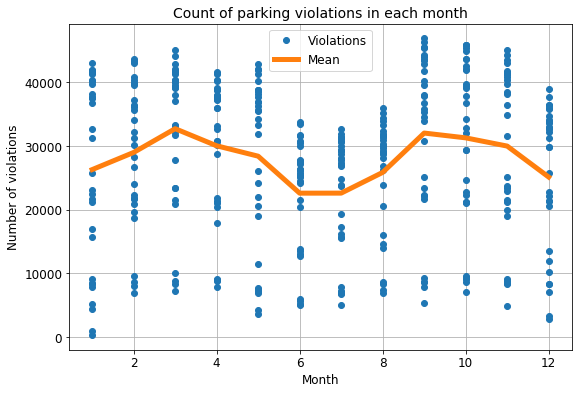

In [10]:
#Make a plot showing the number of violations in each month and showing the mean of violations in each month
monthList = []
countList = []
for key in sorted(violationDateCount):
    monthList.append(key.strftime("%m"))
    countList.append(violationDateCount[key])

#Build list of all count for each month:
violationMonthCount = {}
for month,count in zip(monthList,countList):
    try:
        violationMonthCount[month].append(count)
    except KeyError:
        violationMonthCount[month] = [count]
    
#Compute mean of each list, break into separate lists for plotting:
monthLine = sorted(violationMonthCount.keys())
countLine = []
for month in monthLine:
    correspondingCount = violationMonthCount[month]
    mean = np.mean(correspondingCount)
    countLine.append(mean)  

plt.figure(figsize=(9,6))
plt.plot(monthList, countList, 'o', label="Violations")
plt.plot(monthLine, countLine, '-', linewidth=5, label="Mean")
plt.title("Count of parking violations in each month", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of violations", fontsize=12)
plt.tick_params(labelsize=12)
plt.grid()
plt.legend(fontsize=12)
#plt.savefig('all.png')
plt.show()

This figure also shows previous conclusion that during June to August, less parking violations occurred.

### 3. Answer if it tends to happen in the morning, afternoon, or evening when there is a parking violation.

First, violation time should be processed and stored as datetime object, because violation time is stored as a string like 1037A, which refers to 10:37 AM.

In [11]:
#Process the violation date and time
violationTimeList = []

for summons in violationWithoutMissingDict:
    try:
        violation = violationWithoutMissingDict[summons]
        
        #Date
        date = violation['Issue Date']
        #Hour
        if violation['Violation Time'][:2] == "00" and violation['Violation Time'][-1:] == "A":
            hour = "12"
        else:
            hour = violation['Violation Time'][:2]
        #Minute   
        minute = violation['Violation Time'][2:4]
        if int(minute) < 0 or int(minute) > 59:
            continue
        #AM or PM   
        ampm = violation['Violation Time'][-1:] + 'M'

        time = date + ' ' + hour + ' ' + ampm
        violationTimeList.append(datetime.datetime.strptime(time, "%m/%d/%Y %I %p"))
            
    except ValueError:
        #print(summons)
        continue

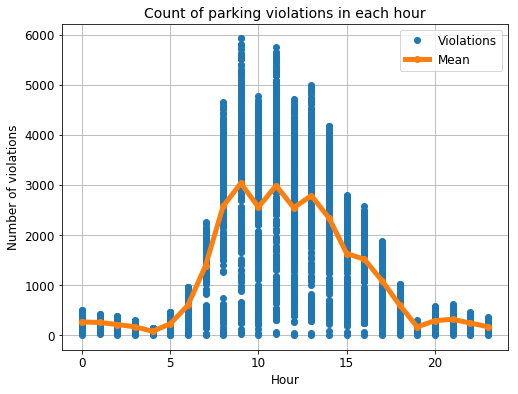

In [12]:
#Make a plot showing the number of violations in each hour and showing the mean of violations in each hour
violationTimeCount = Counter(violationTimeList)
hourList = []
countList = []
for key in sorted(violationTimeCount):
    hourList.append(key.strftime("%H"))
    countList.append(violationTimeCount[key])

#Build list of all count for each month:
violationHourCount = {}
for hour,count in zip(hourList,countList):
    try:
        violationHourCount[hour].append(count)
    except KeyError:
        violationHourCount[hour] = [count]
    
#Compute mean of each list, break into separate lists for plotting:
hourLine = sorted(violationHourCount.keys())
countLine = []
for hour in hourLine:
    correspondingCount = violationHourCount[hour]
    mean = np.mean(correspondingCount)
    countLine.append(mean)  

plt.figure(figsize=(8,6))
plt.plot(hourList, countList, 'o', label="Violations")
plt.plot(hourLine, countLine, 'o-', linewidth=5, label="Mean")
plt.title("Count of parking violations in each hour", fontsize=14)
plt.xlabel("Hour", fontsize=12)
plt.ylabel("Number of violations", fontsize=12)
plt.tick_params(labelsize=12)
plt.grid()
plt.legend(fontsize=12)
#plt.savefig('all.png')
plt.show()

This figure shows that during 8 AM to 2 PM, there were relatively higher numbers of parking violation. Therefore, we can not conclude that parking violations occurred more in the morning or in the afternoon. Instead, the higher result ranges between 8 to 14 in 24-hour clock.

### 4\. Answer if daily average temperature influences the number of parking violations.

To answer this question, we should process NYC weather dataset first. This dataset contains the highest and lowest temperatures on each day in 2016.

In [13]:
#Read daily weather data in 2016 to a dictionary mapping date to weather information
with open('data/NYC_Weather_Centralpark_2016.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    weatherDict = {}
    for row in reader:
        weatherInfoDict = {}
        date = datetime.datetime.strptime(row['date'], "%d-%m-%Y")
        if date in weatherDict:
            print("Duplicate date: ", end='')
            print(row['date'])
        else:
            weatherInfoDict['maximum temperature'] = (float)(row['maximum temperature'])
            weatherInfoDict['minimum temperature'] = (float)(row['minimum temperature'])
            weatherInfoDict['average temperature'] = (float)(row['average temperature'])
            weatherDict[date] = weatherInfoDict
            


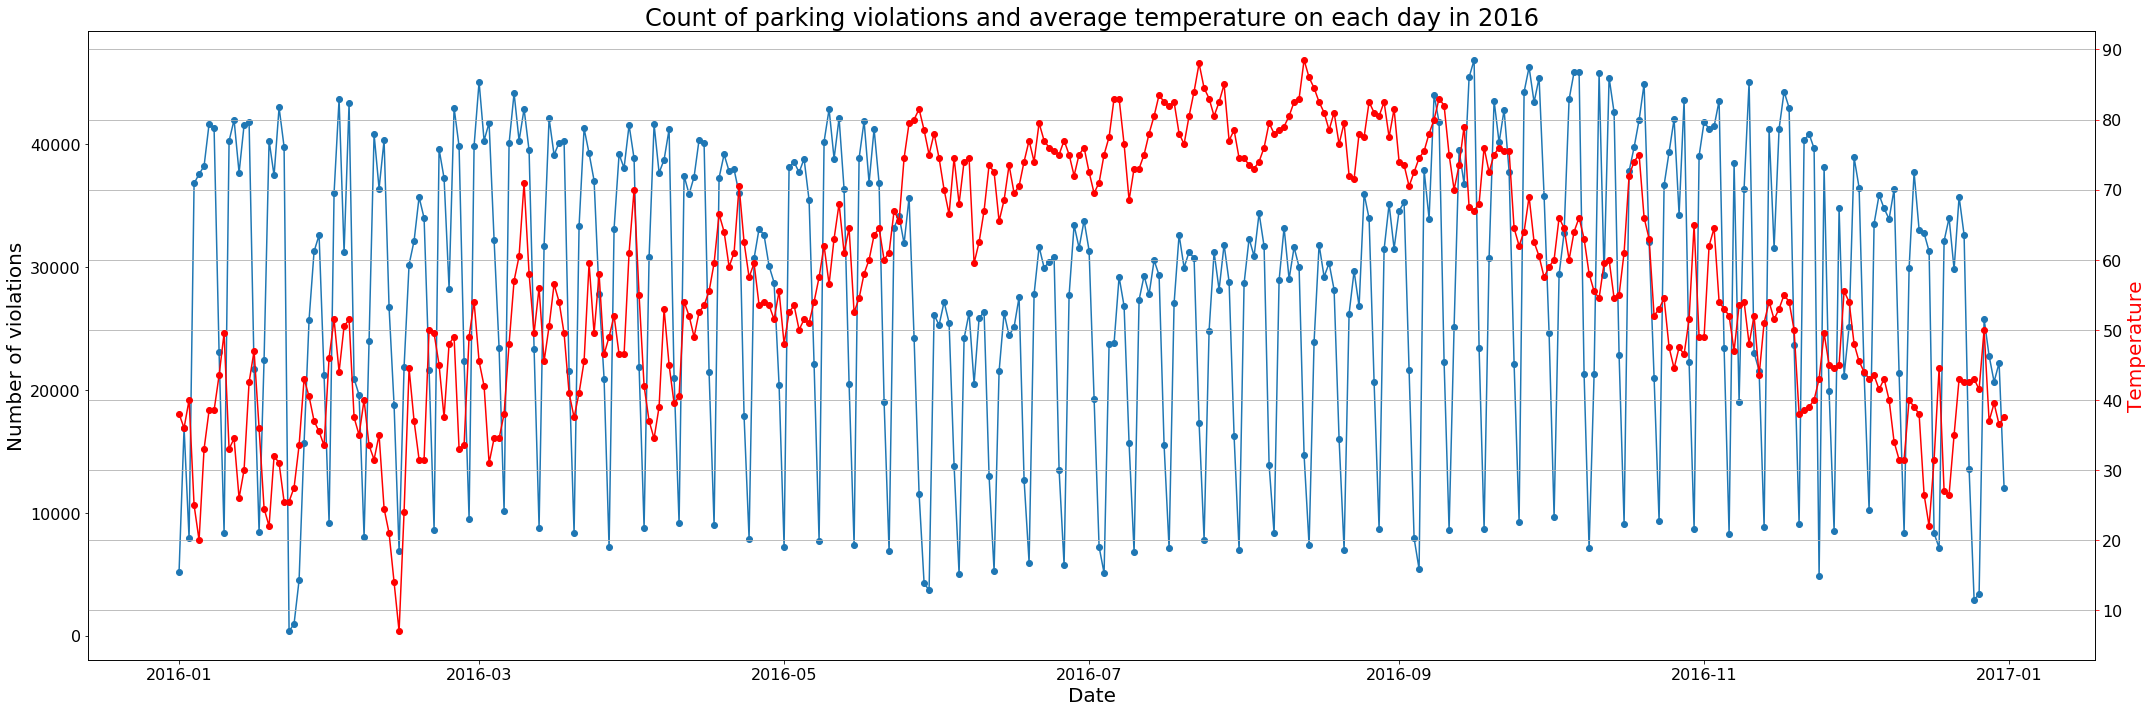

In [14]:
#Make a plot showing the number of violations and average temperature on each day
violationDateCount = Counter(violationDateList)
dateList = []
countList = []

for key in sorted(violationDateCount):
    dateList.append(key)
    countList.append(violationDateCount[key])

dateList2 = []
tempList = []
for date in weatherDict:
    dateList2.append(date)
    tempList.append(weatherDict[date]['average temperature'])

fig, ax1 = plt.subplots(figsize=(30,10))

plt.title("Count of parking violations and average temperature on each day in 2016", fontsize=24)

ax1.plot(dateList, countList, 'o-')
ax1.set_xlabel("Date", fontsize=20)
ax1.set_ylabel("Number of violations", fontsize=20)
ax1.tick_params('y', labelsize=16)
ax1.tick_params('x', labelsize=16)

ax2 = ax1.twinx()
ax2.plot(dateList2, tempList, 'o-', color='r')
ax2.set_xlabel("Date", fontsize=20)
ax2.set_ylabel("Temperature", fontsize=20, color='r')
ax2.tick_params('y', color='r', labelsize=16)


fig.tight_layout()
plt.grid()
plt.show()

The figure is too ambiguous because when temperature is too high or too low, people feel worse than a medium temperature. Therefore, the base temperature is set as 70 and the difference between the temperature on that day and the base is divided by 5 to determine the degree of uncomfortable feeling. 

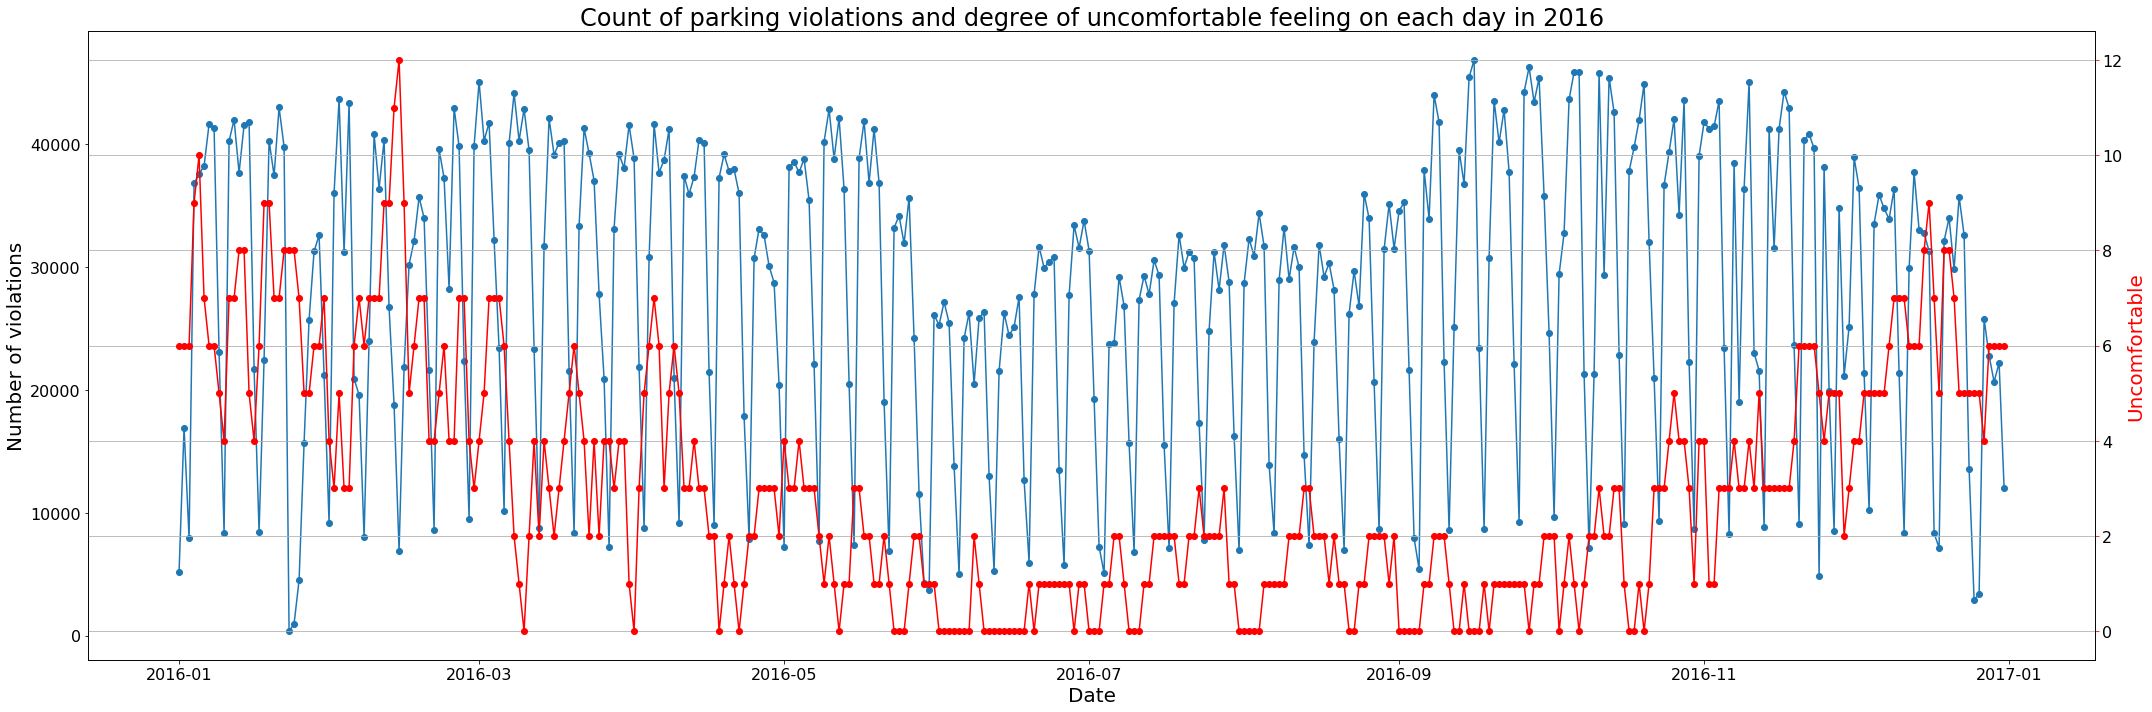

In [15]:
#Calculate the degree of uncomfortable feeling for each temperature 
#and plot the degree and the number of violations on the same day together
dateList2 = []
uncomfortableList = []
for date in weatherDict:
    dateList2.append(date)
    temperature = float(weatherDict[date]['average temperature'])
    temperature = abs(temperature-70)
    uncomfortableList.append((int)(temperature/5))

fig, ax1 = plt.subplots(figsize=(30,10))

plt.title("Count of parking violations and degree of uncomfortable feeling on each day in 2016", fontsize=24)

ax1.plot(dateList, countList, 'o-')
ax1.set_xlabel("Date", fontsize=20)
ax1.set_ylabel("Number of violations", fontsize=20)
ax1.tick_params('y', labelsize=16)
ax1.tick_params('x', labelsize=16)

ax2 = ax1.twinx()
ax2.plot(dateList2, uncomfortableList, 'o-', color='r')
ax2.set_xlabel("Date", fontsize=20)
ax2.set_ylabel("Uncomfortable", fontsize=20, color='r')
ax2.tick_params('y', color='r', labelsize=16)

fig.tight_layout()
plt.grid()
plt.show()

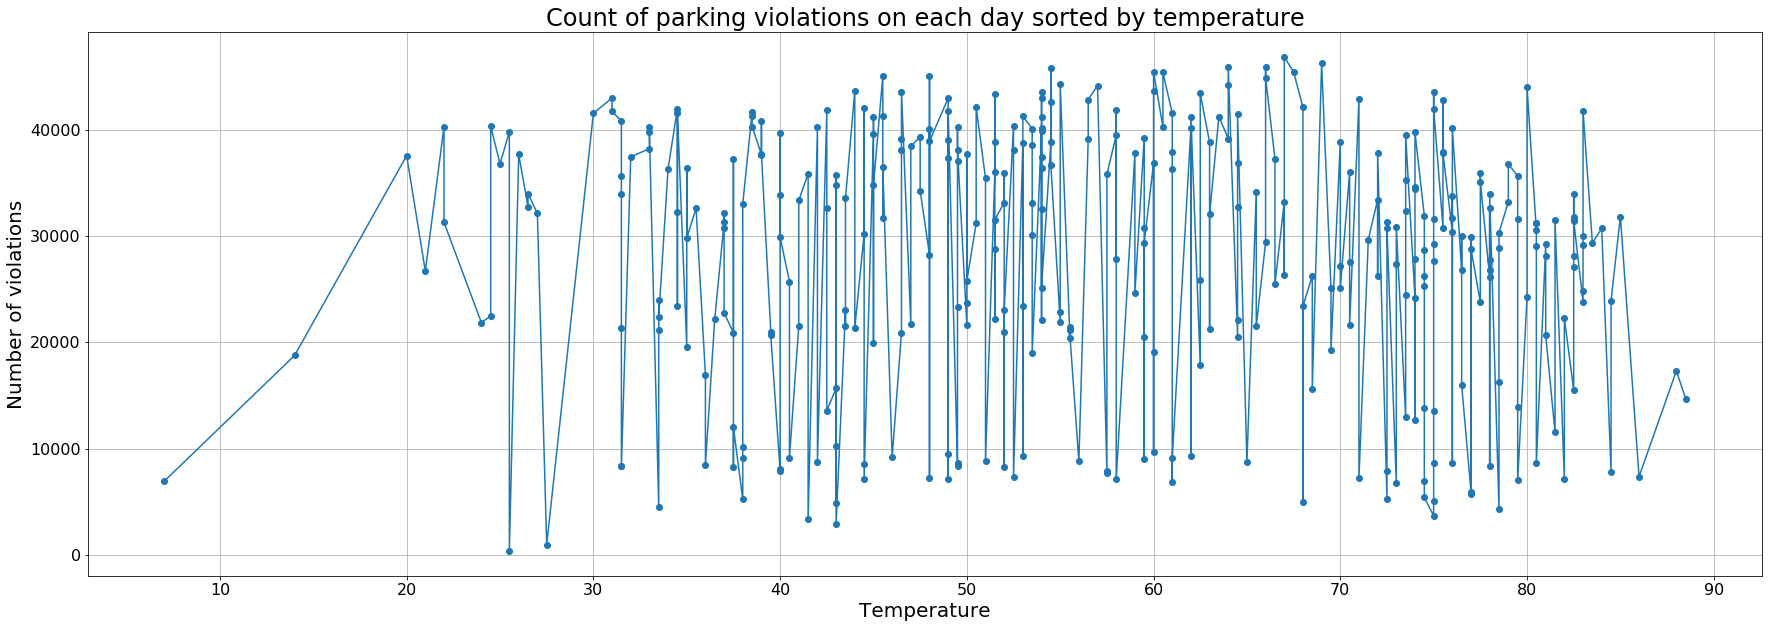

In [16]:
#Make a plot showing the relation of violations and temperature
sortDateByTemp = sorted([(weatherDict[date]['average temperature'], date) for date in weatherDict])
tempList = [temp for temp,date in sortDateByTemp]
countList = [violationDateCount[date] for temp,date in sortDateByTemp]

plt.figure(figsize=(30,10))
plt.plot(tempList, countList, 'o-')
plt.title("Count of parking violations on each day sorted by temperature", fontsize=24)
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Number of violations", fontsize=20)
plt.tick_params(labelsize=16)
plt.grid()
#plt.legend(fontsize=20)
#plt.savefig('all.png')
plt.show()

The relation of parking violations and temperature might be too weak to be shown in the figure.

### 5\. Answer if hourly outside temperature influences the number of parking violations.

To do this, we should first process the hourly weather data and store the data in a dictionary.

In [17]:
#Read hourly weather data in 2016 to a dictionary mapping date and time to weather information
with open('data/NYC_Hourly_Weather_2016.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    hourlyweatherDict = {} 
    for row in reader:
        hourlyweatherInfoDict = {}
        if row['pickup_datetime'][:4] != "2016":
            continue
        time = datetime.datetime.strptime(row['pickup_datetime'][:-6], "%Y-%m-%d %H")
        if time not in hourlyweatherDict:
            hourlyweatherInfoDict['icon'] = row['icon']
            hourlyweatherInfoDict['rain'] = row['rain']
            try:
                hourlyweatherInfoDict['tempi'] = (float)(row['tempi'])
            except ValueError:
                hourlyweatherInfoDict['tempi'] = None        
            
            
            hourlyweatherDict[time] = hourlyweatherInfoDict
                      

There are 24 hours in a day, so the amount of data might be too large and hard to process. Therefore, the data is classified into different months.

In [18]:
#Classify violations dictionary and temperature dictionary based on month
monthList = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

violationMonthDict = {}
for month in monthList:
    violationMonthDict[month] = {}

for time in violationTimeCount:
    month = time.strftime("%b")
    violationMonthDict[month][time] = violationTimeCount[time]

tempMonthDict = {}
for month in monthList:
    tempMonthDict[month] = {}

for time in hourlyweatherDict:
    month = time.strftime("%b")
    tempMonthDict[month][time] = hourlyweatherDict[time]


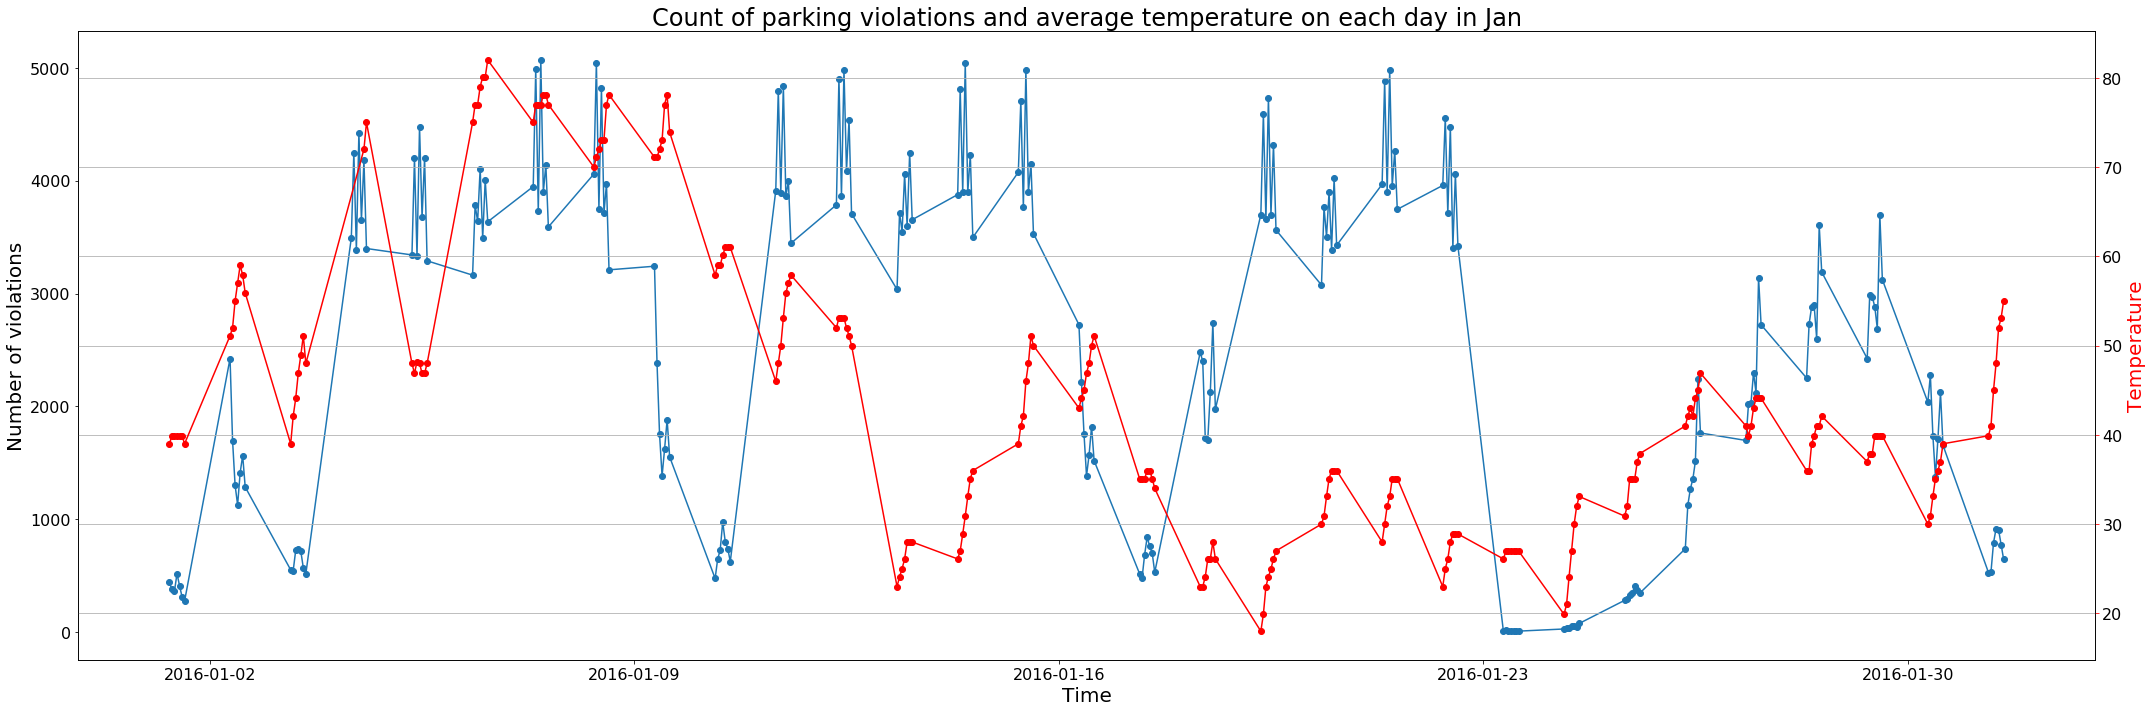

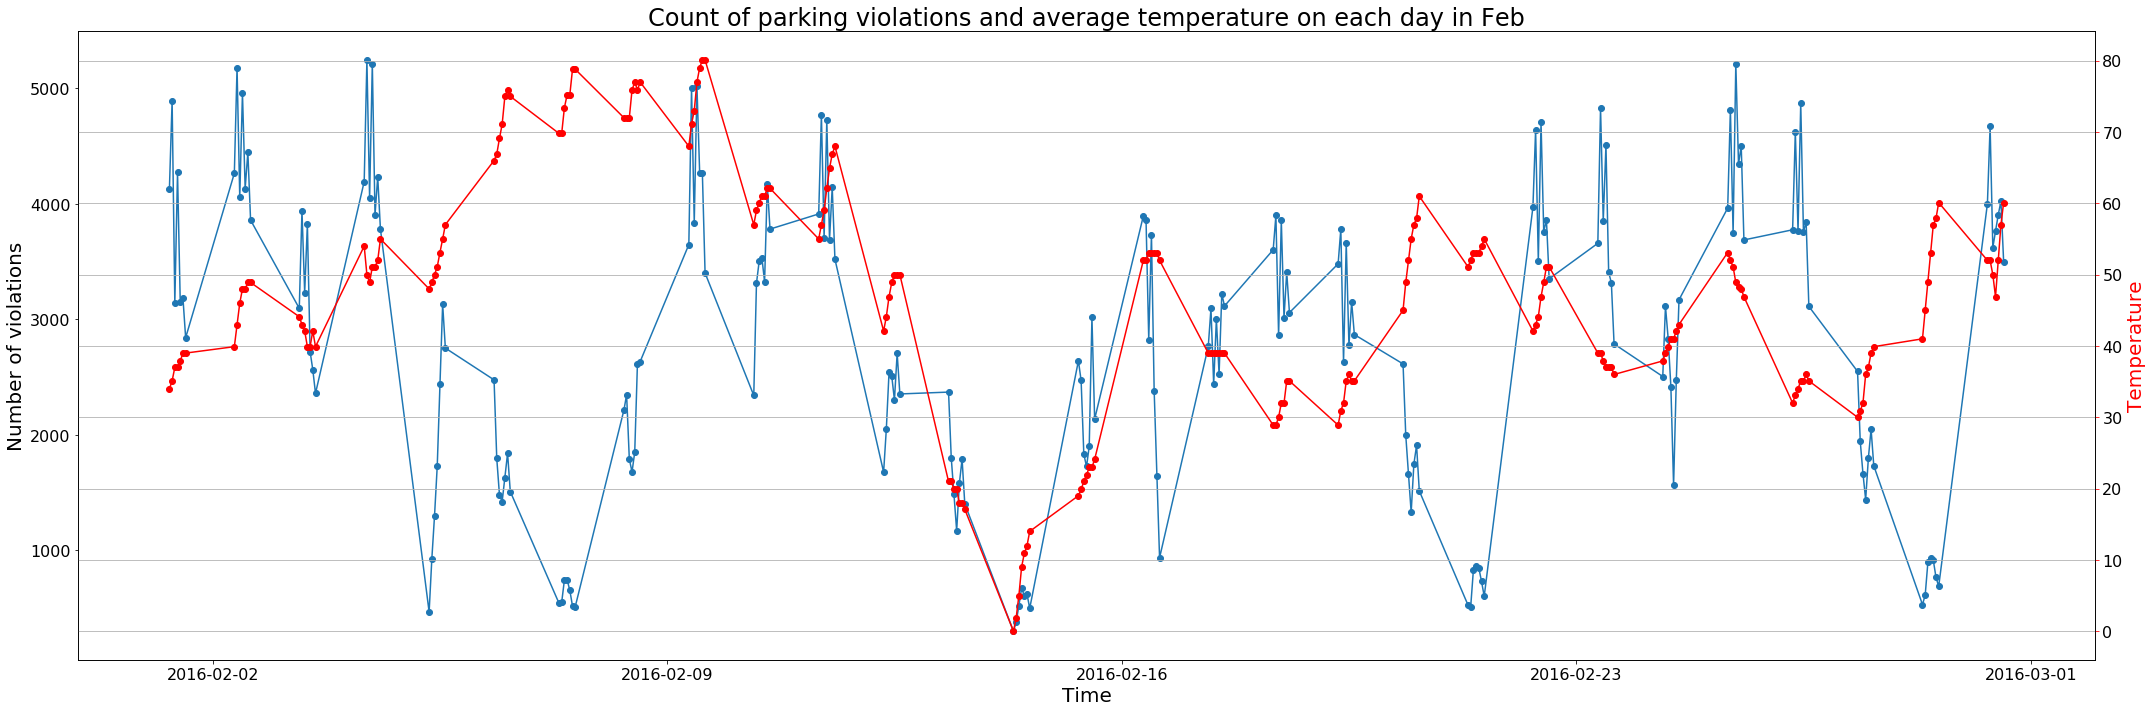

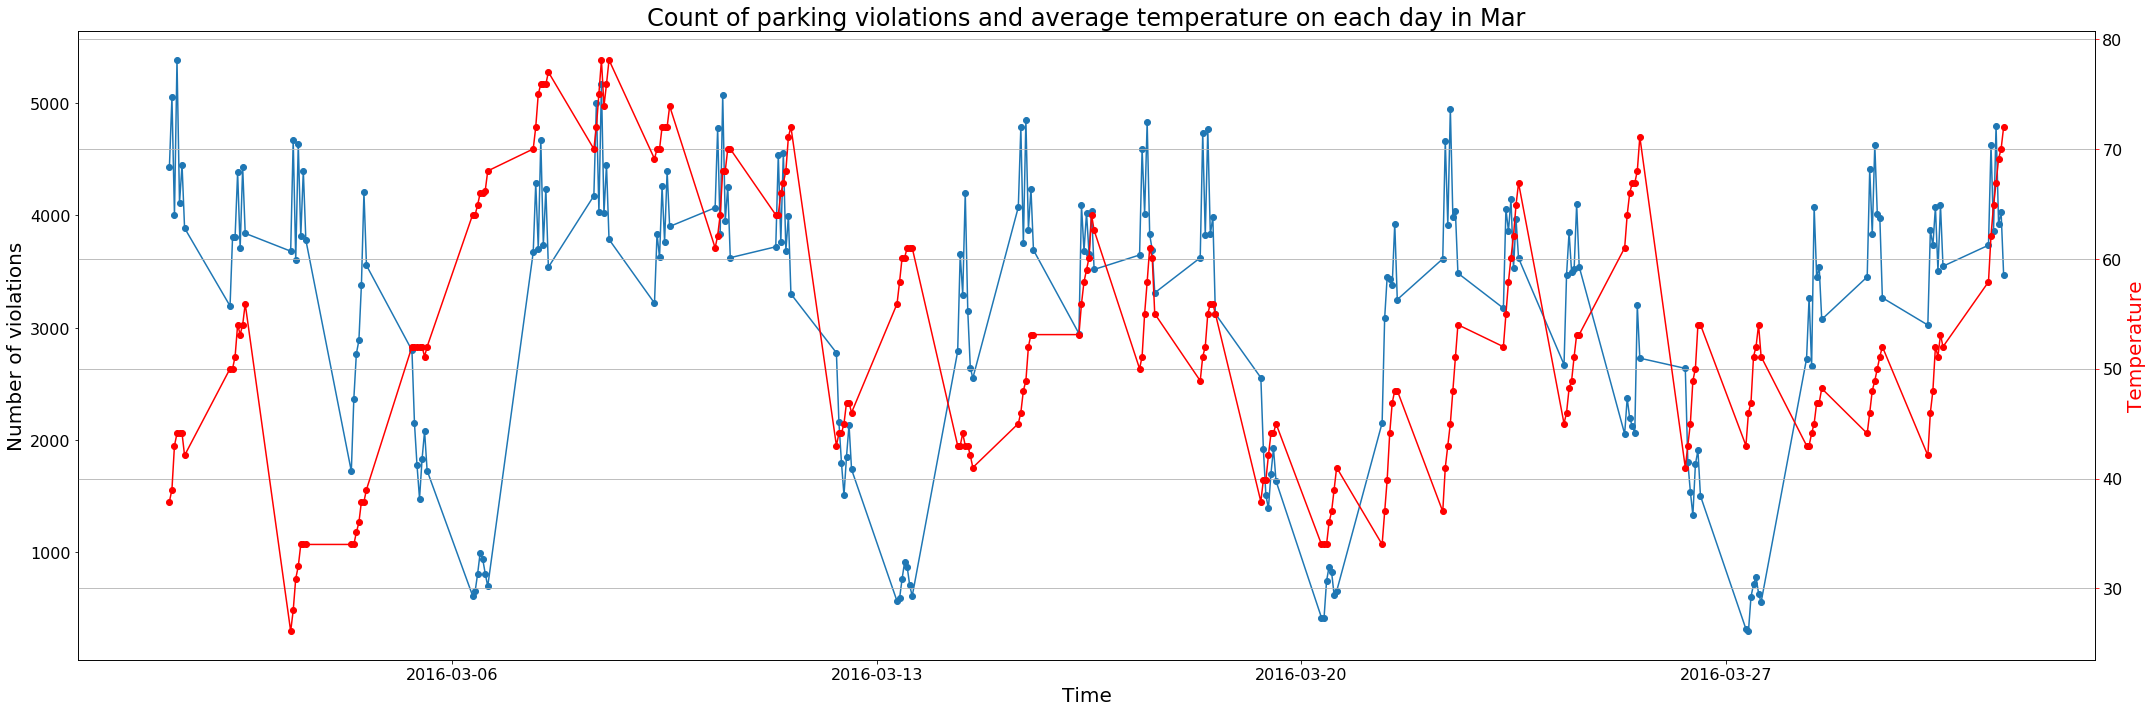

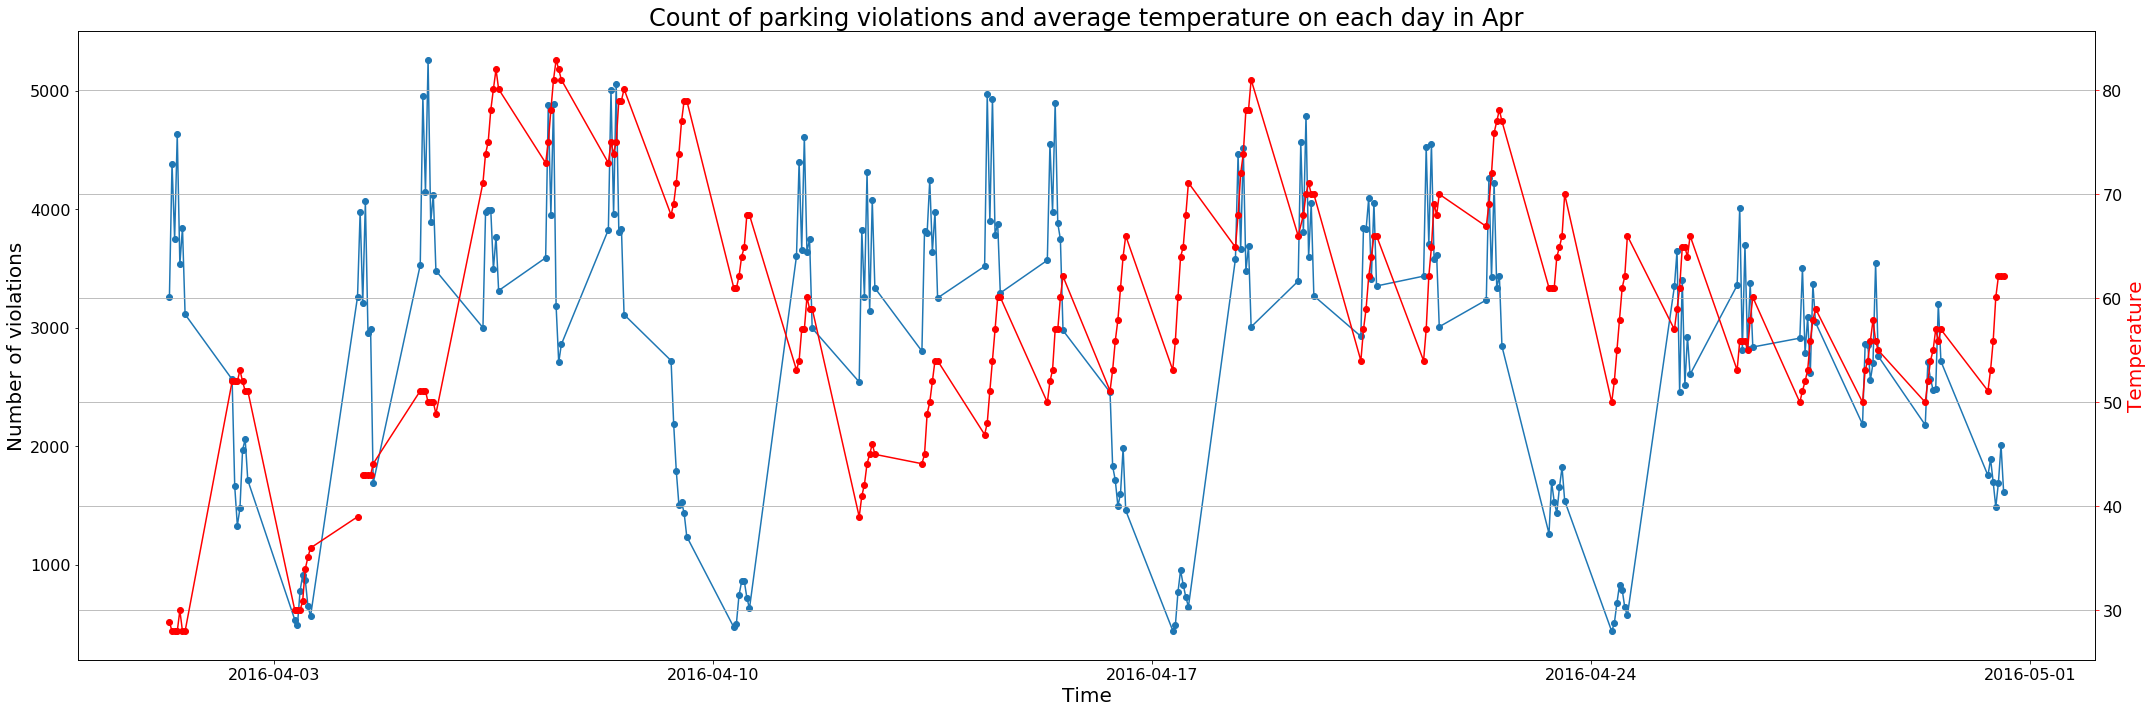

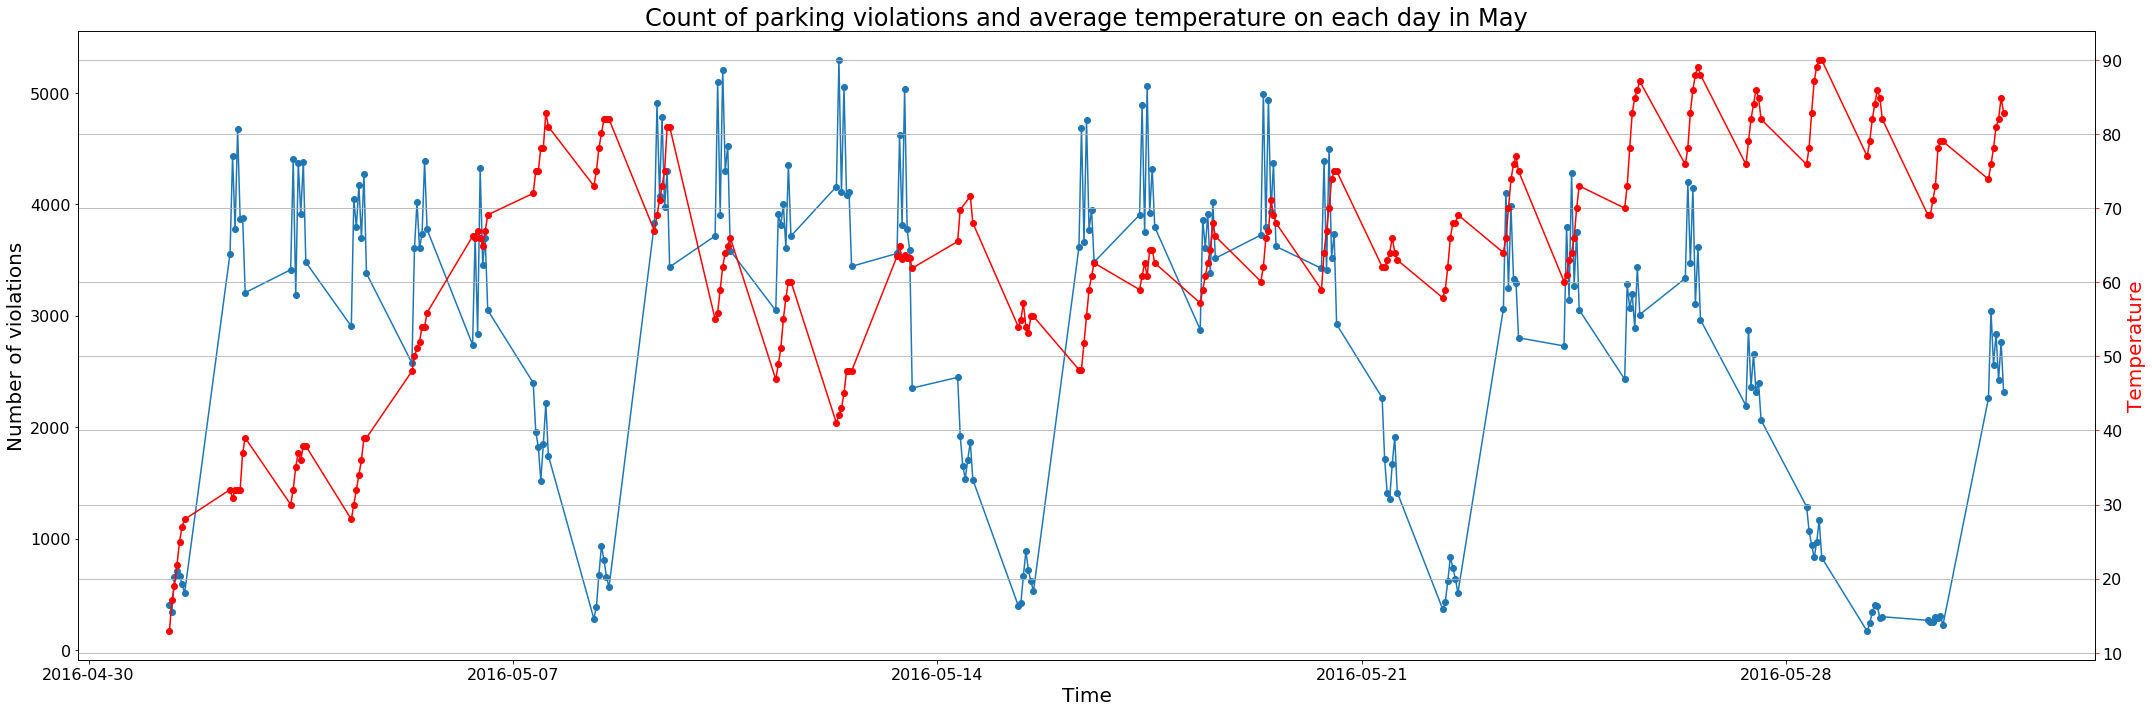

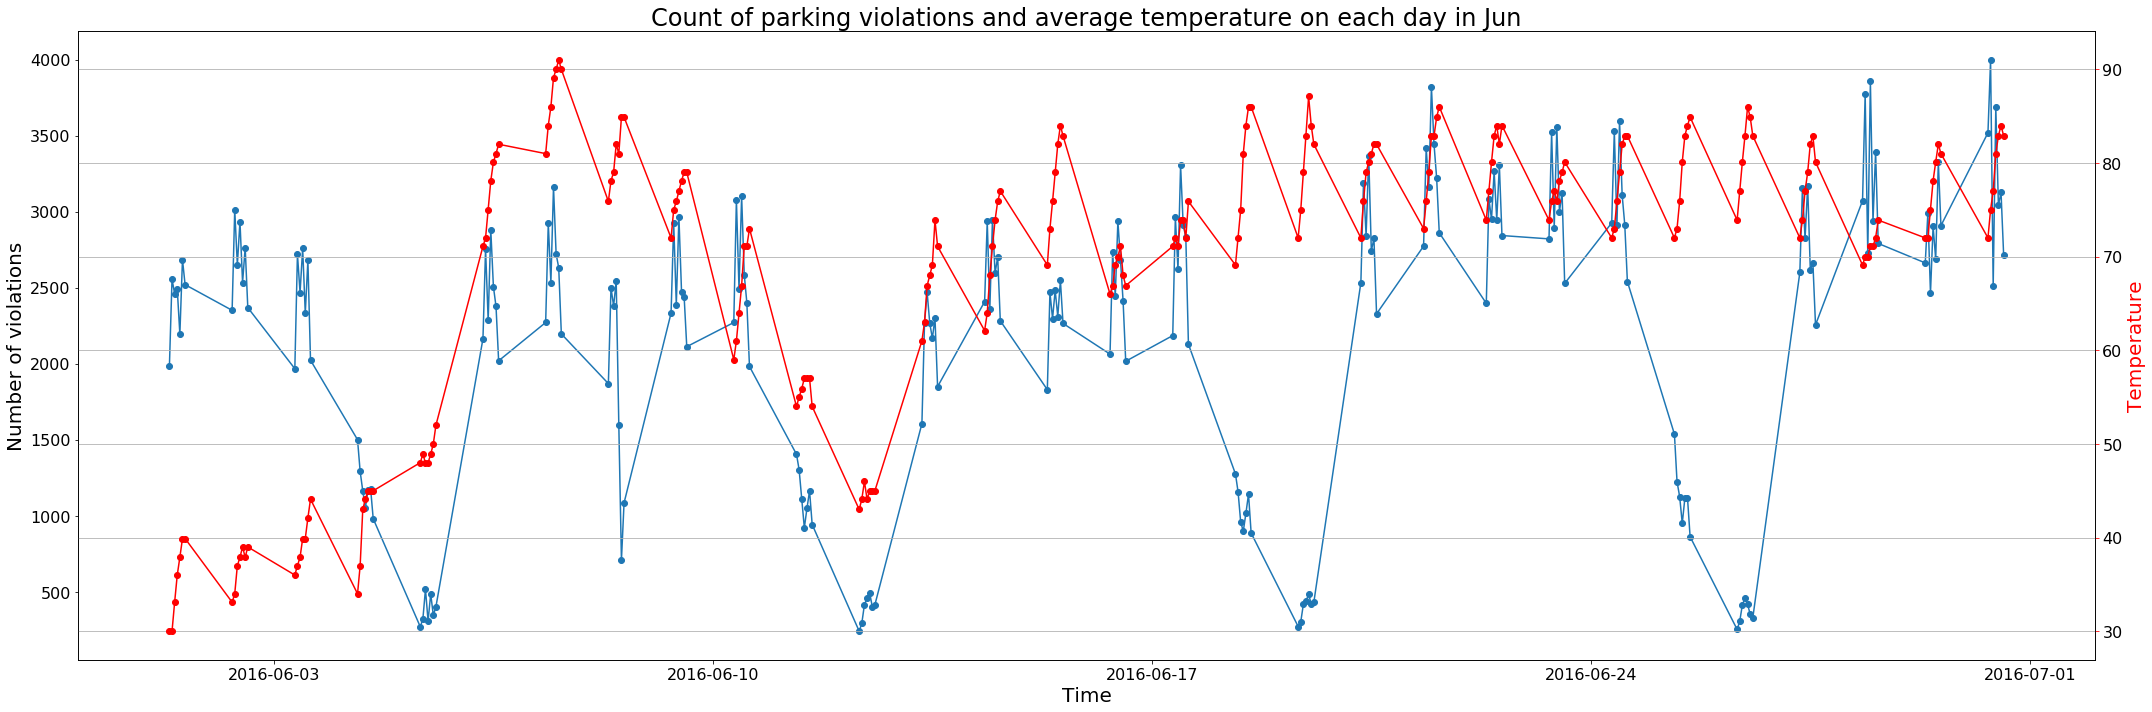

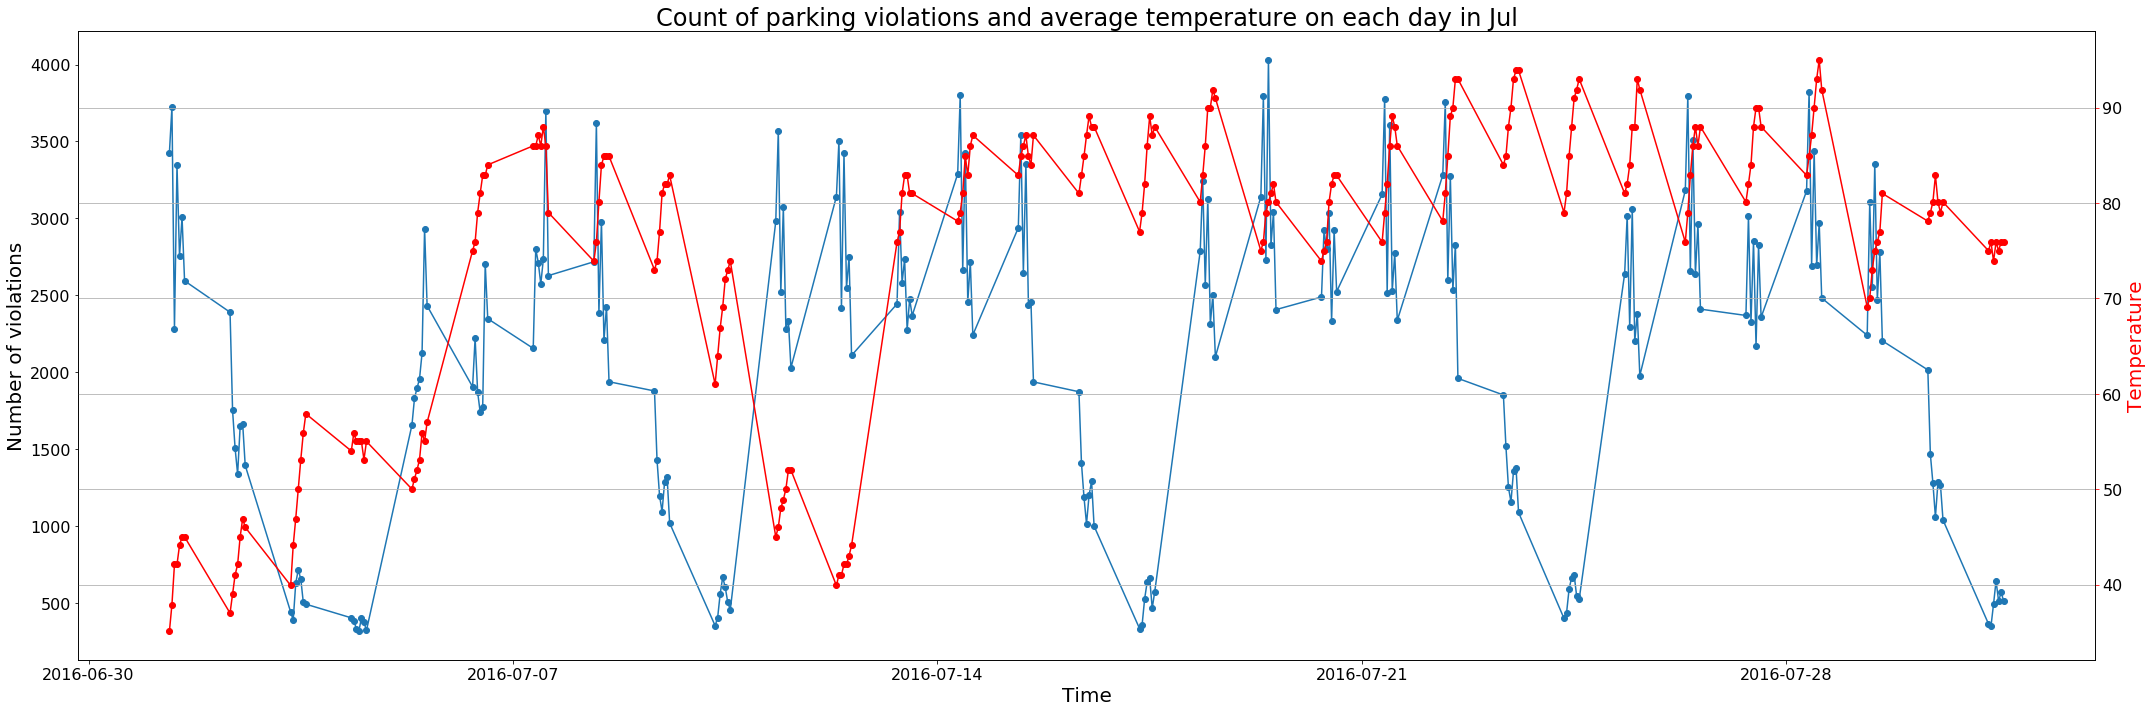

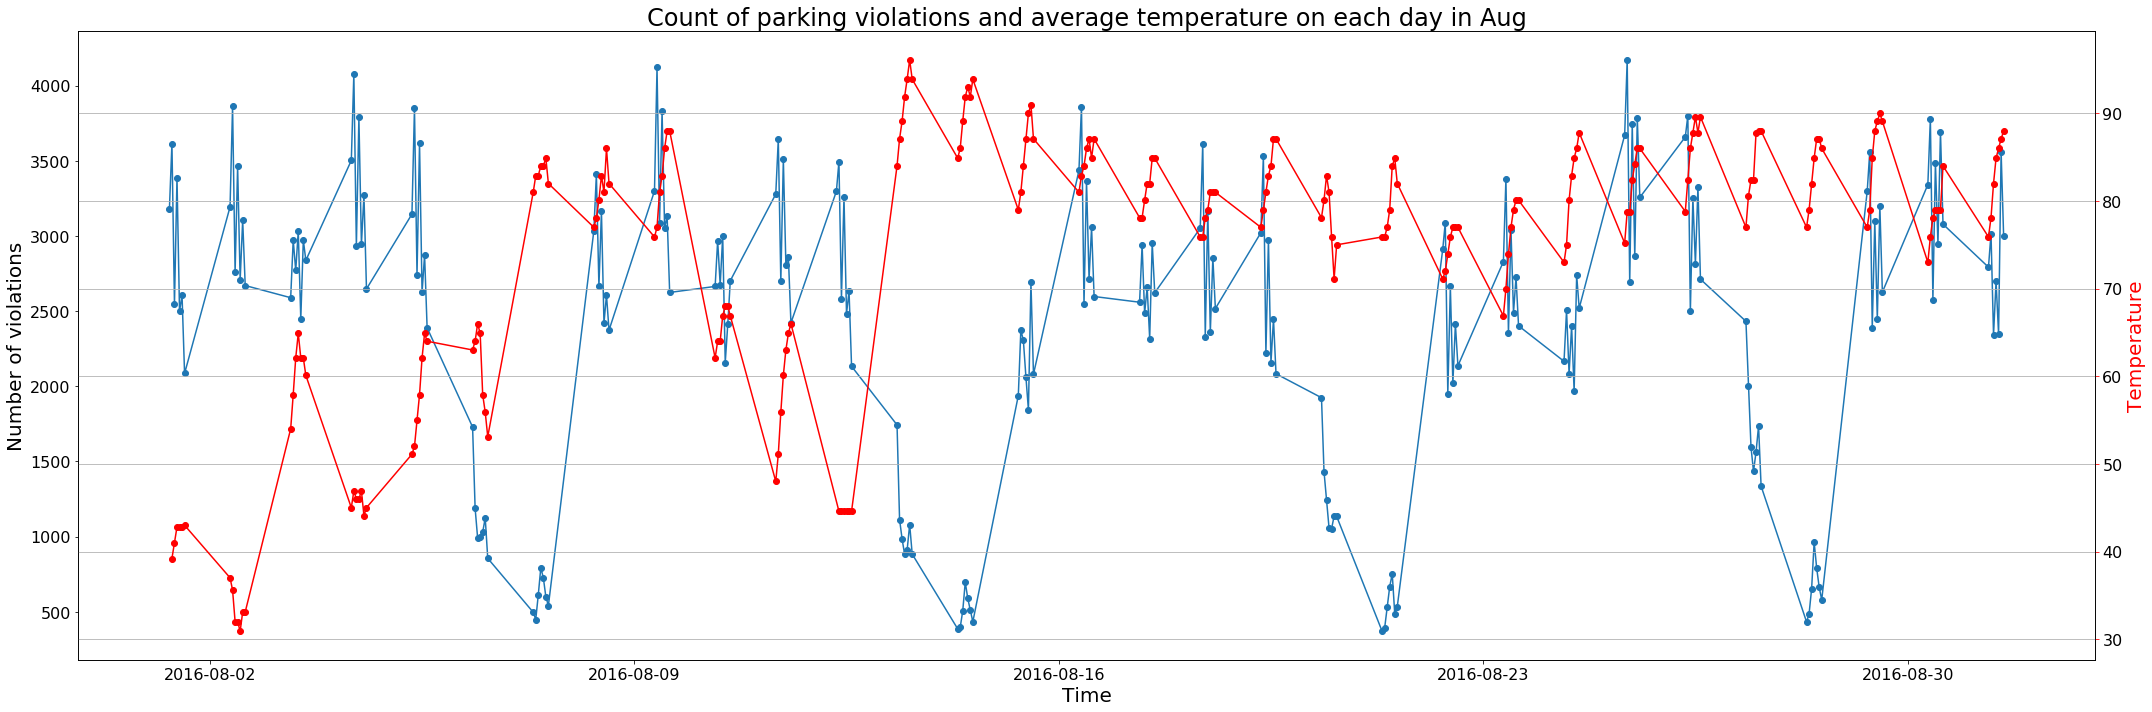

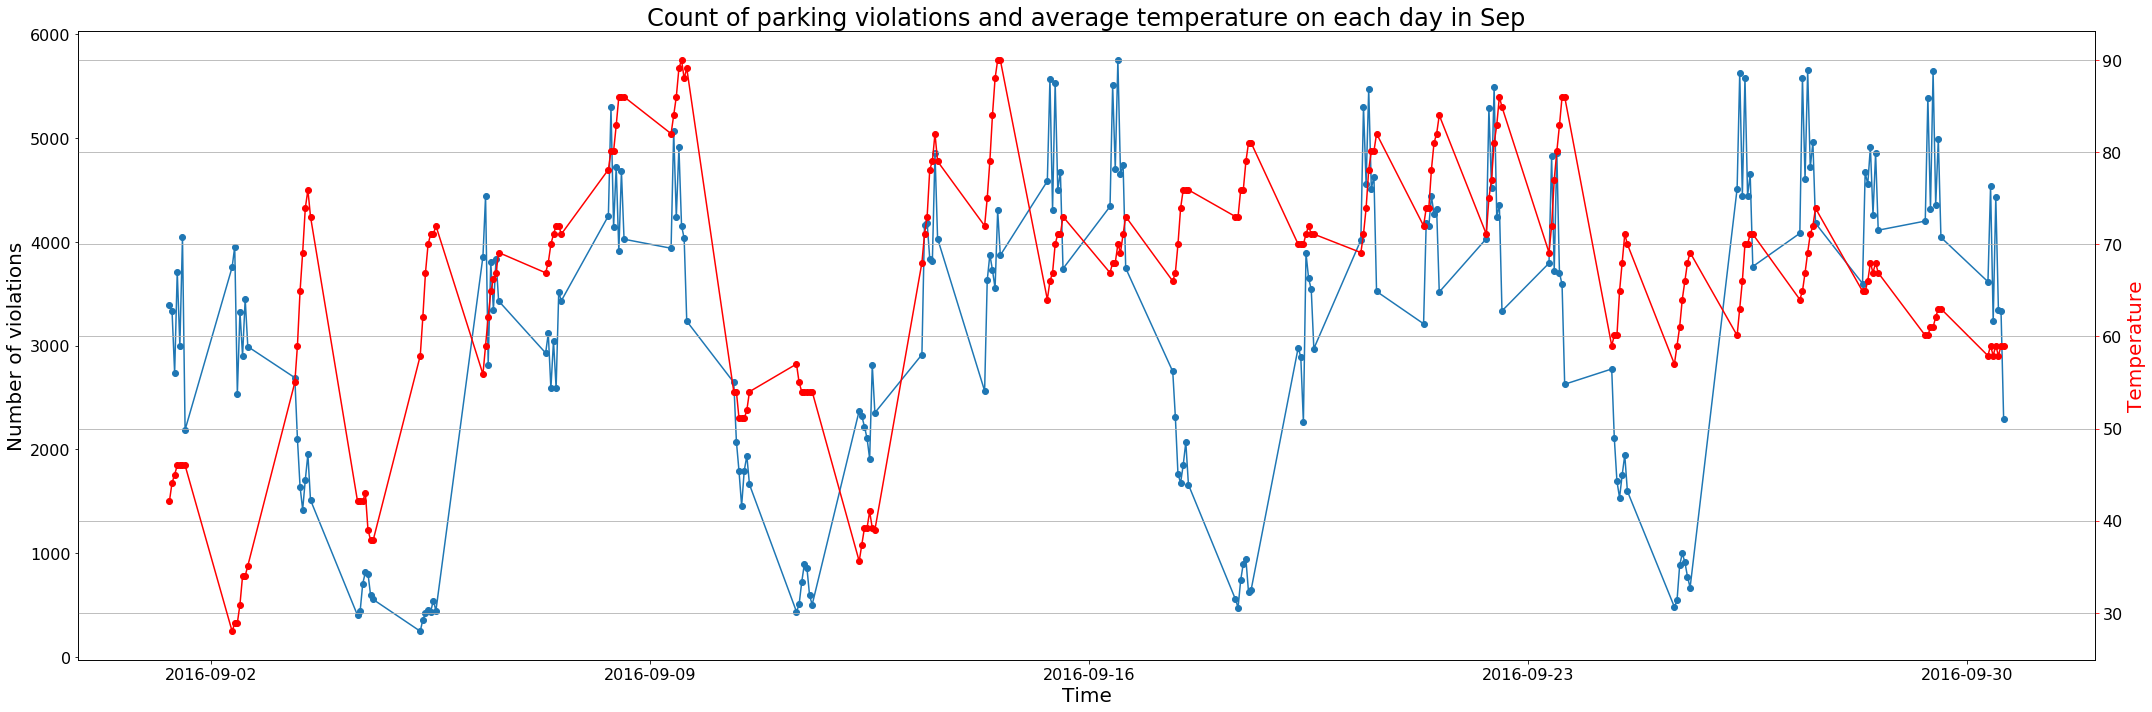

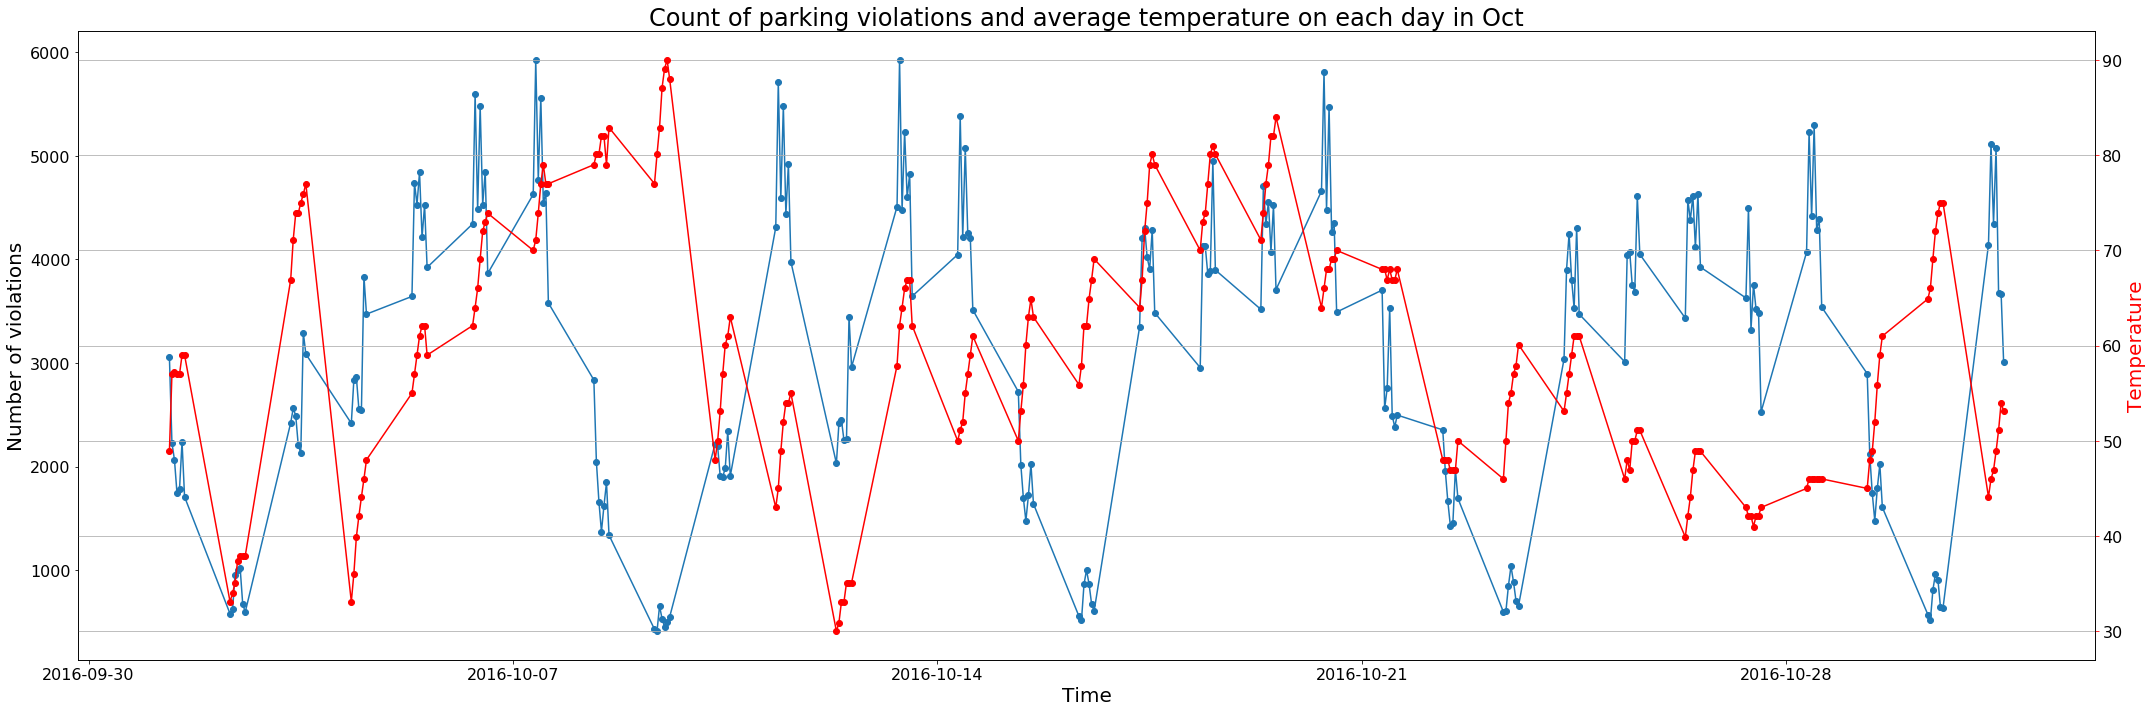

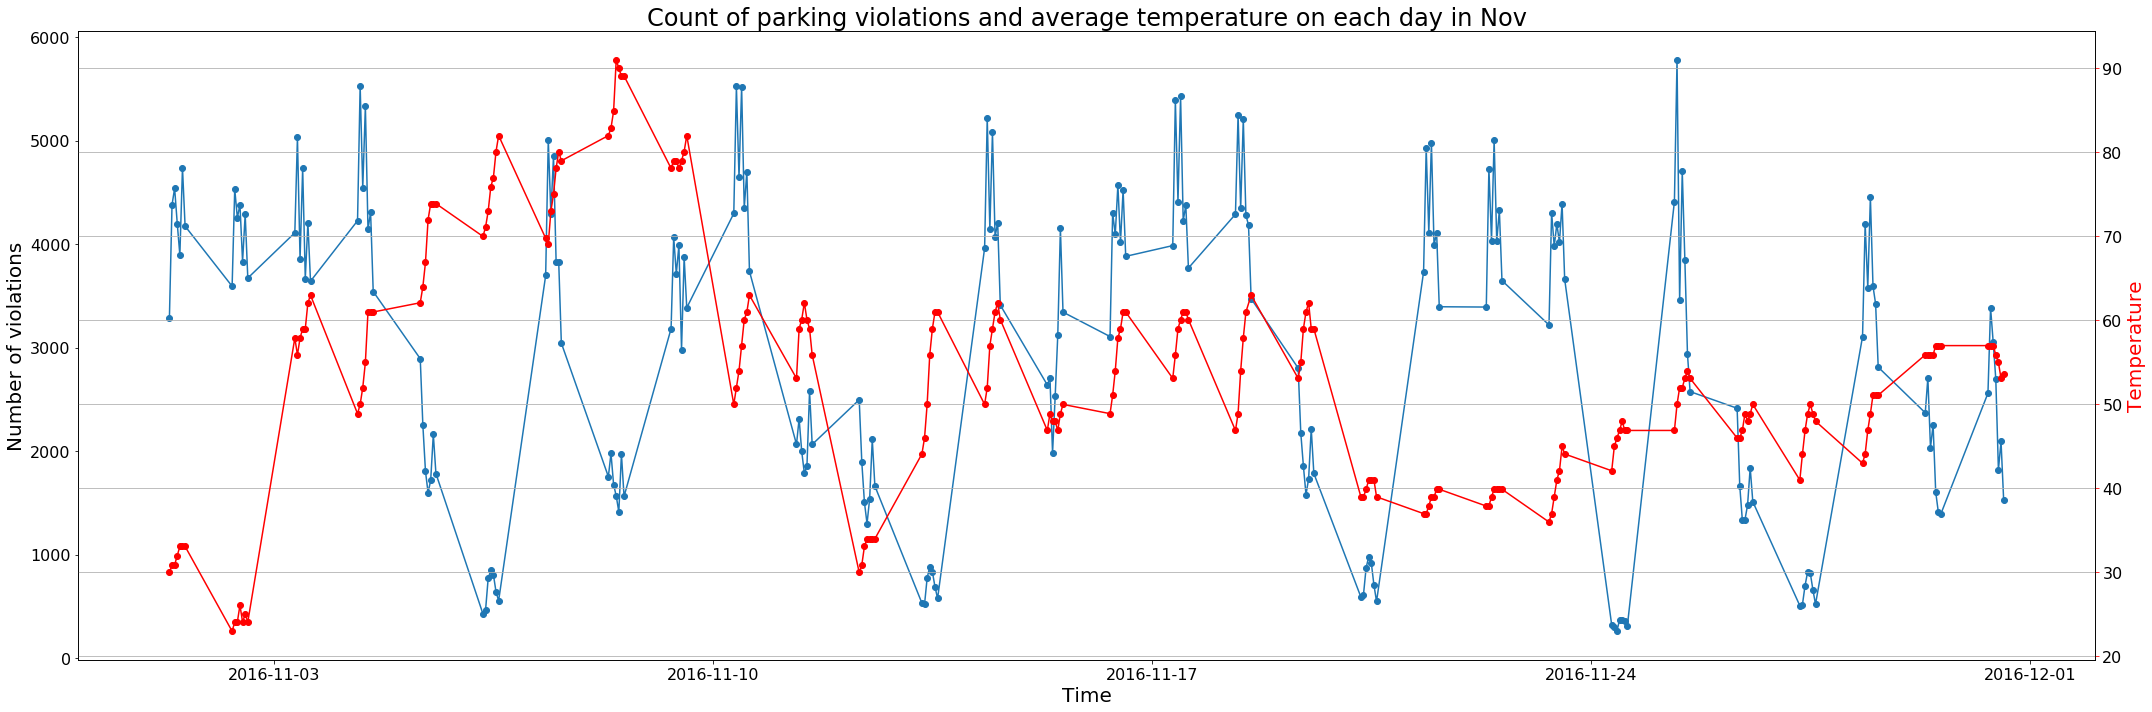

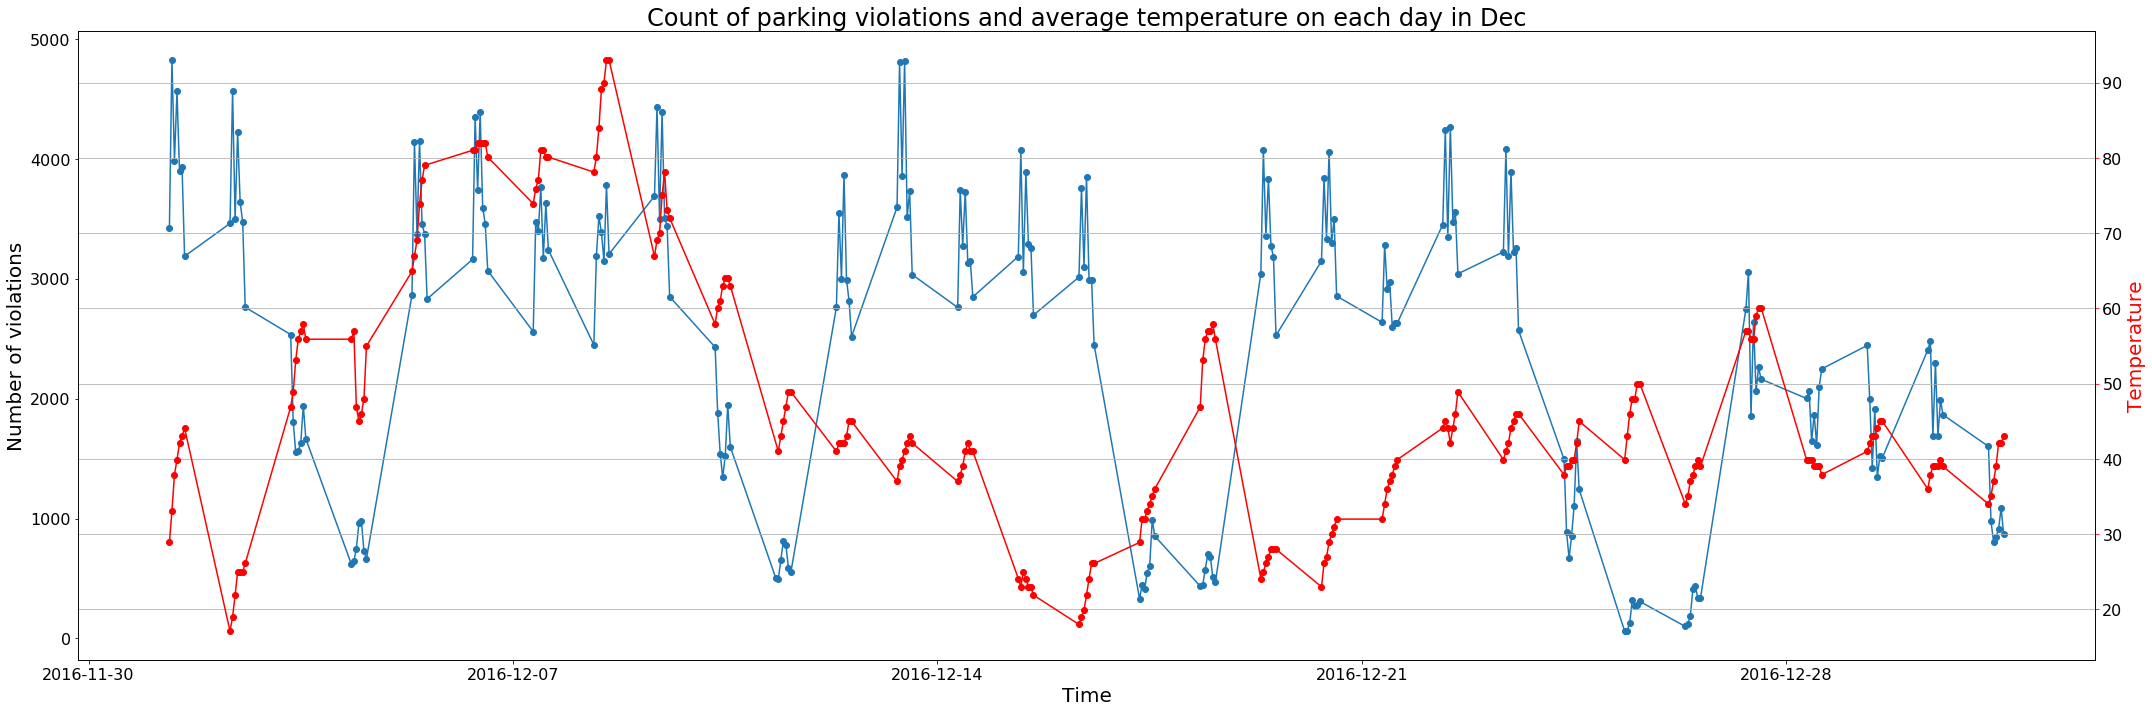

In [19]:
#Make a plot showing the number of violations and the temperature on each hour for every month
for month in monthList:
    hourList = []
    countList = []

    #Only consider data from 8AM to 2PM to simplify the figure
    for time in sorted(violationMonthDict[month]):
        hour = (int)(time.strftime("%H"))
        if hour<8 or hour>14:
            continue
        hourList.append(time)
        countList.append(violationMonthDict[month][time])

    hourList2 = []
    tempList = []
    for time in sorted(tempMonthDict[month]):
        hour = (int)(time.strftime("%H"))
        if hour<8 or hour>14:
            continue
        hourList2.append(time)
        tempList.append(tempMonthDict[month][time]['tempi'])

    fig, ax1 = plt.subplots(figsize=(30,10))
    plt.title("Count of parking violations and average temperature on each day in "+month, fontsize=24)

    ax1.plot(hourList, countList, 'o-')
    ax1.set_xlabel("Time", fontsize=20)
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel("Number of violations", fontsize=20)
    ax1.tick_params('y', labelsize=16)
    ax1.tick_params('x', labelsize=16)
    
    ax2 = ax1.twinx()
    ax2.plot(hourList2, tempList, 'o-', color='r')
    ax2.set_xlabel("Time", fontsize=20)
    ax2.set_ylabel("Temperature", fontsize=20, color='r')
    ax2.tick_params('y', color='r', labelsize=16)

    fig.tight_layout()
    plt.grid()
    plt.show()

The temperature is ambiguous because when temperature is too high or too low, people feel worse than a medium temperature. Therefore, temperature is changed to the degree of uncomfortable feeling for each month.

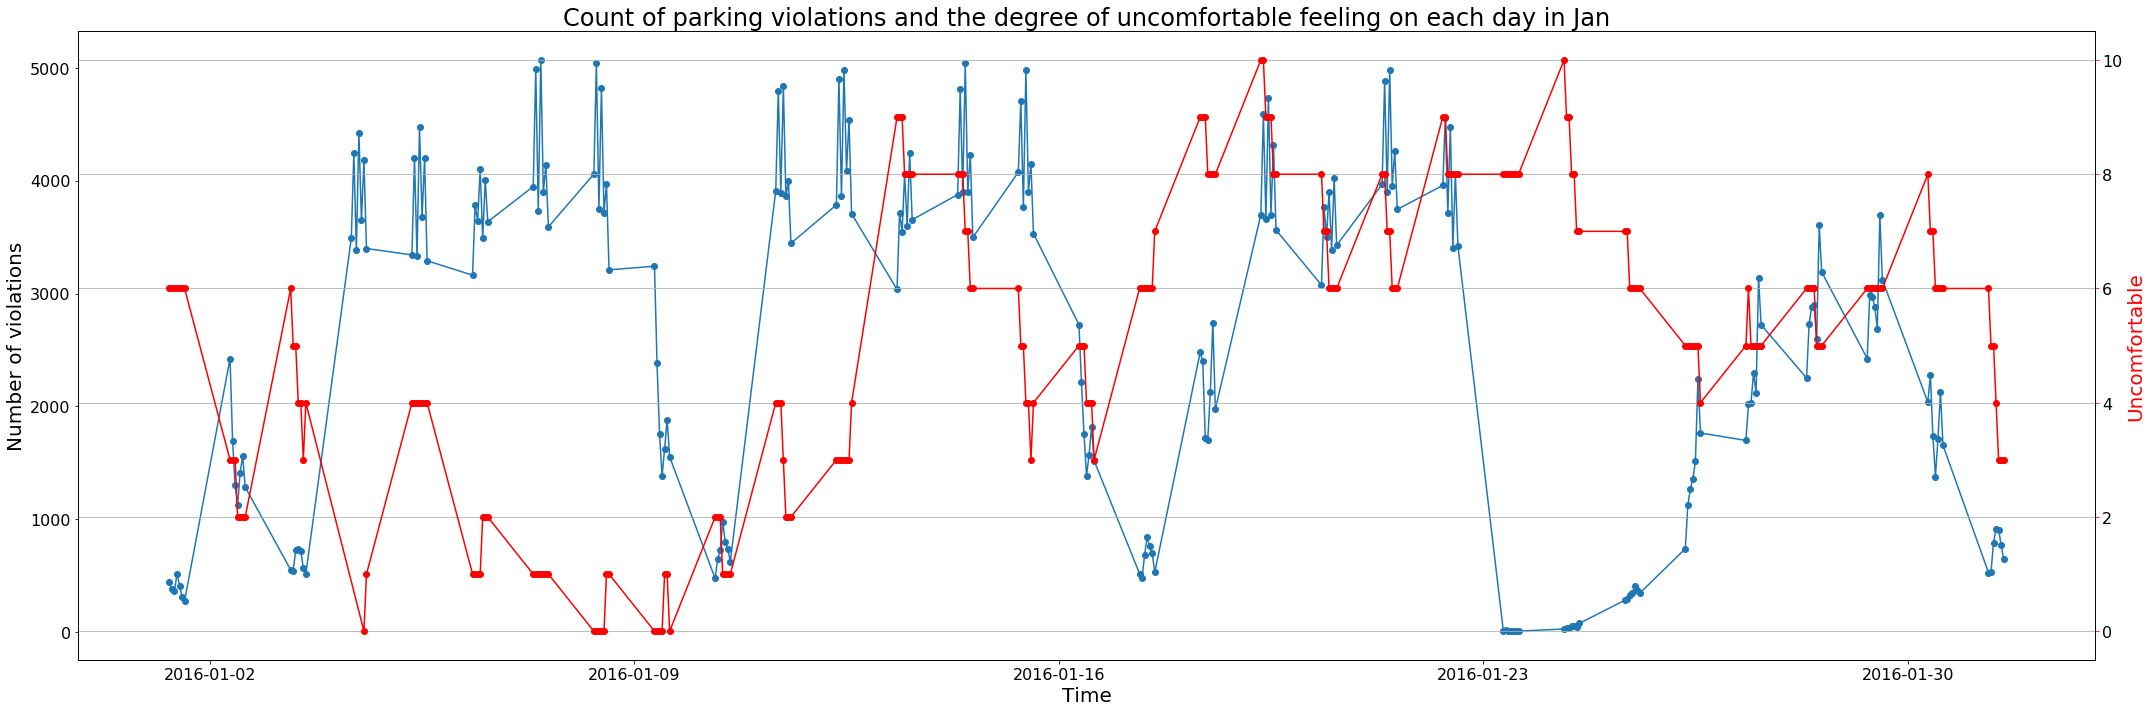

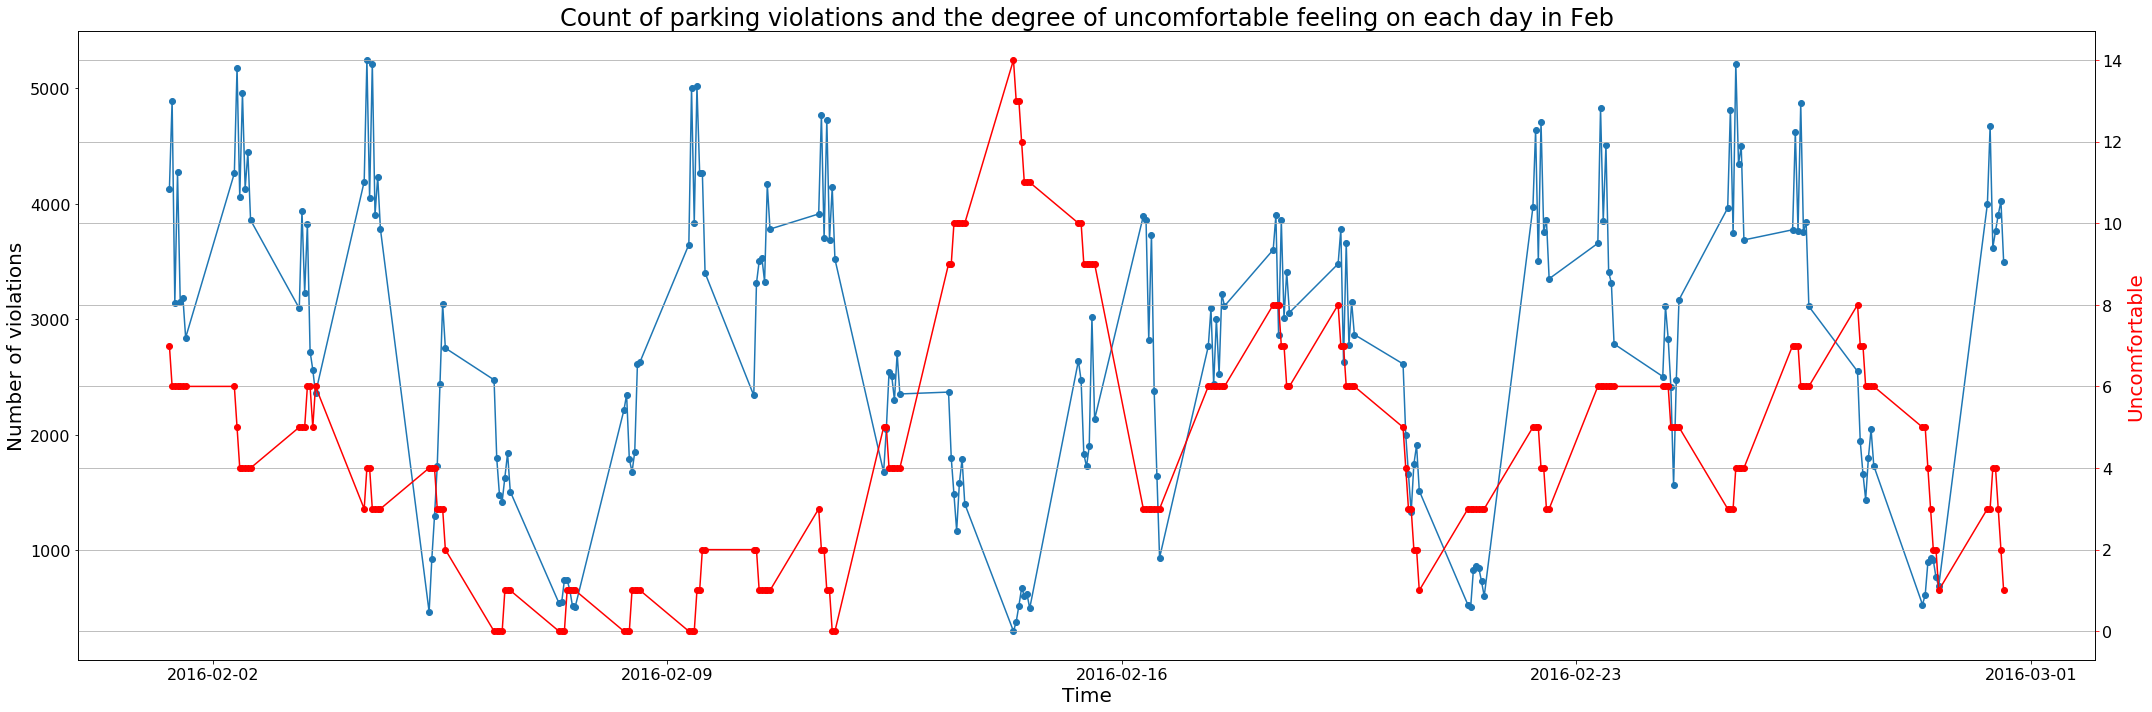

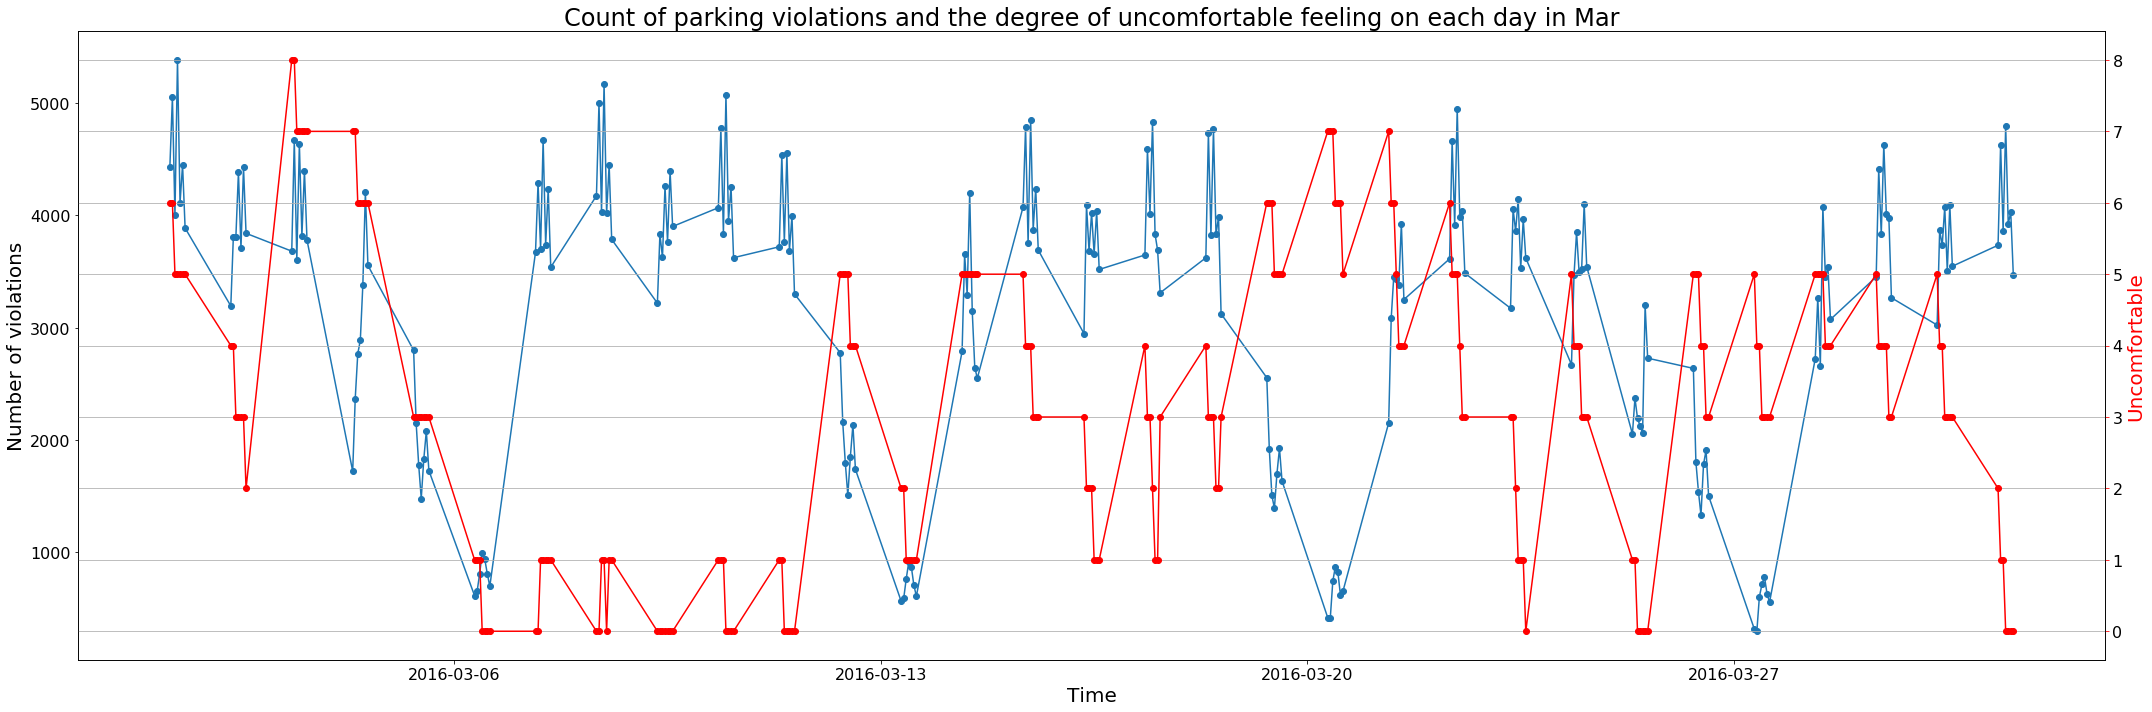

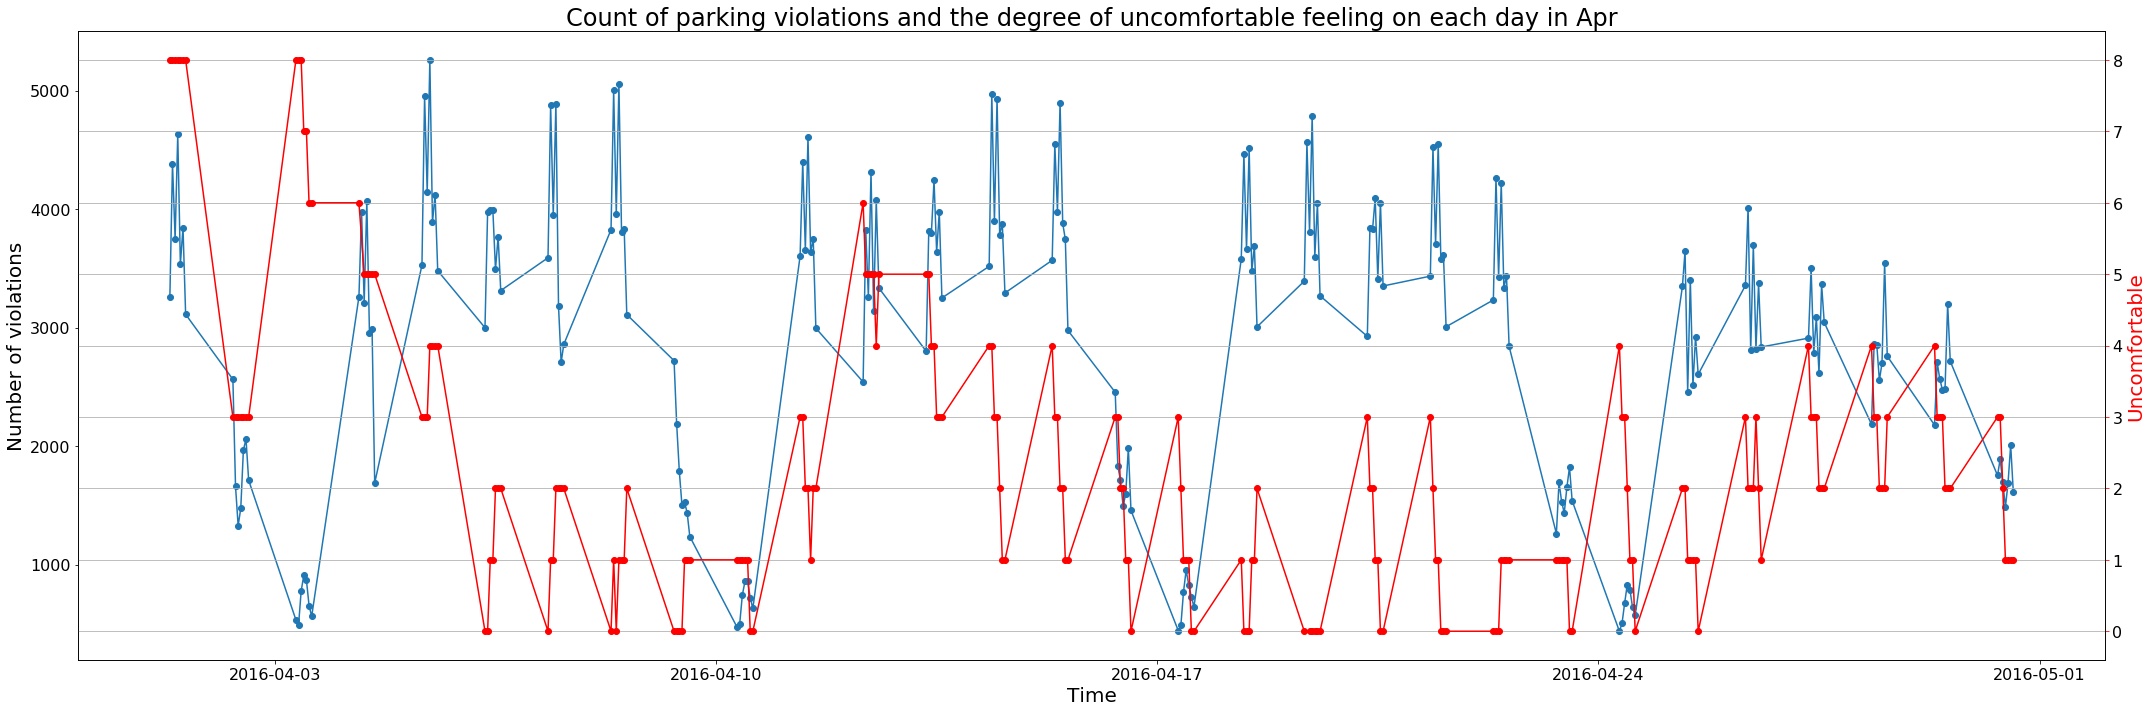

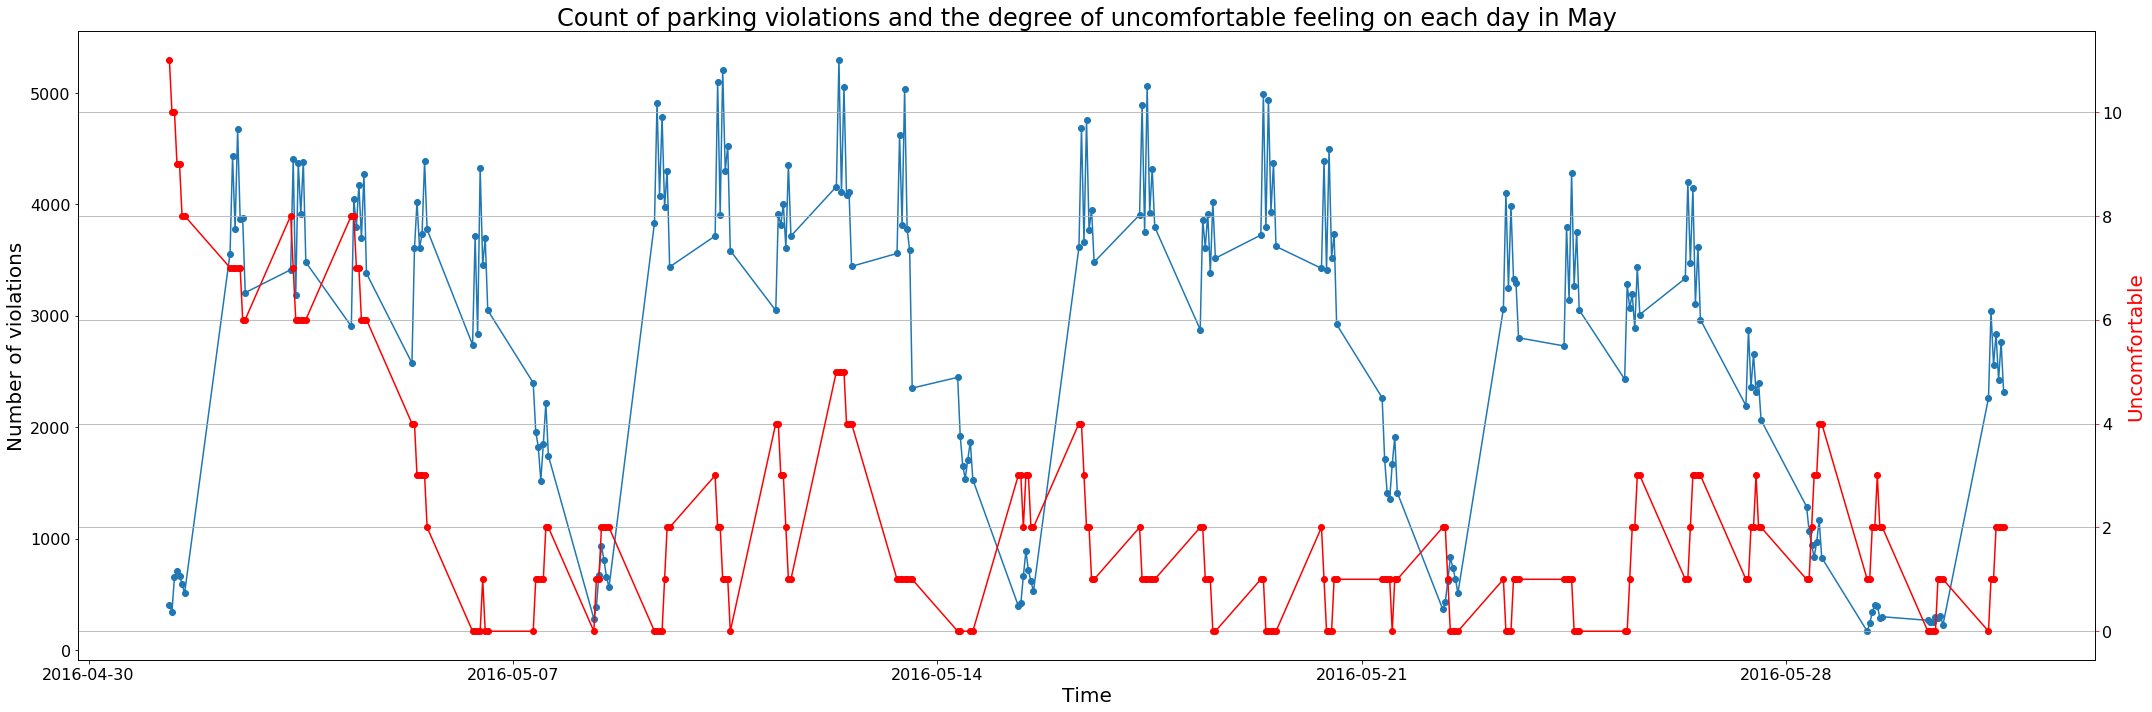

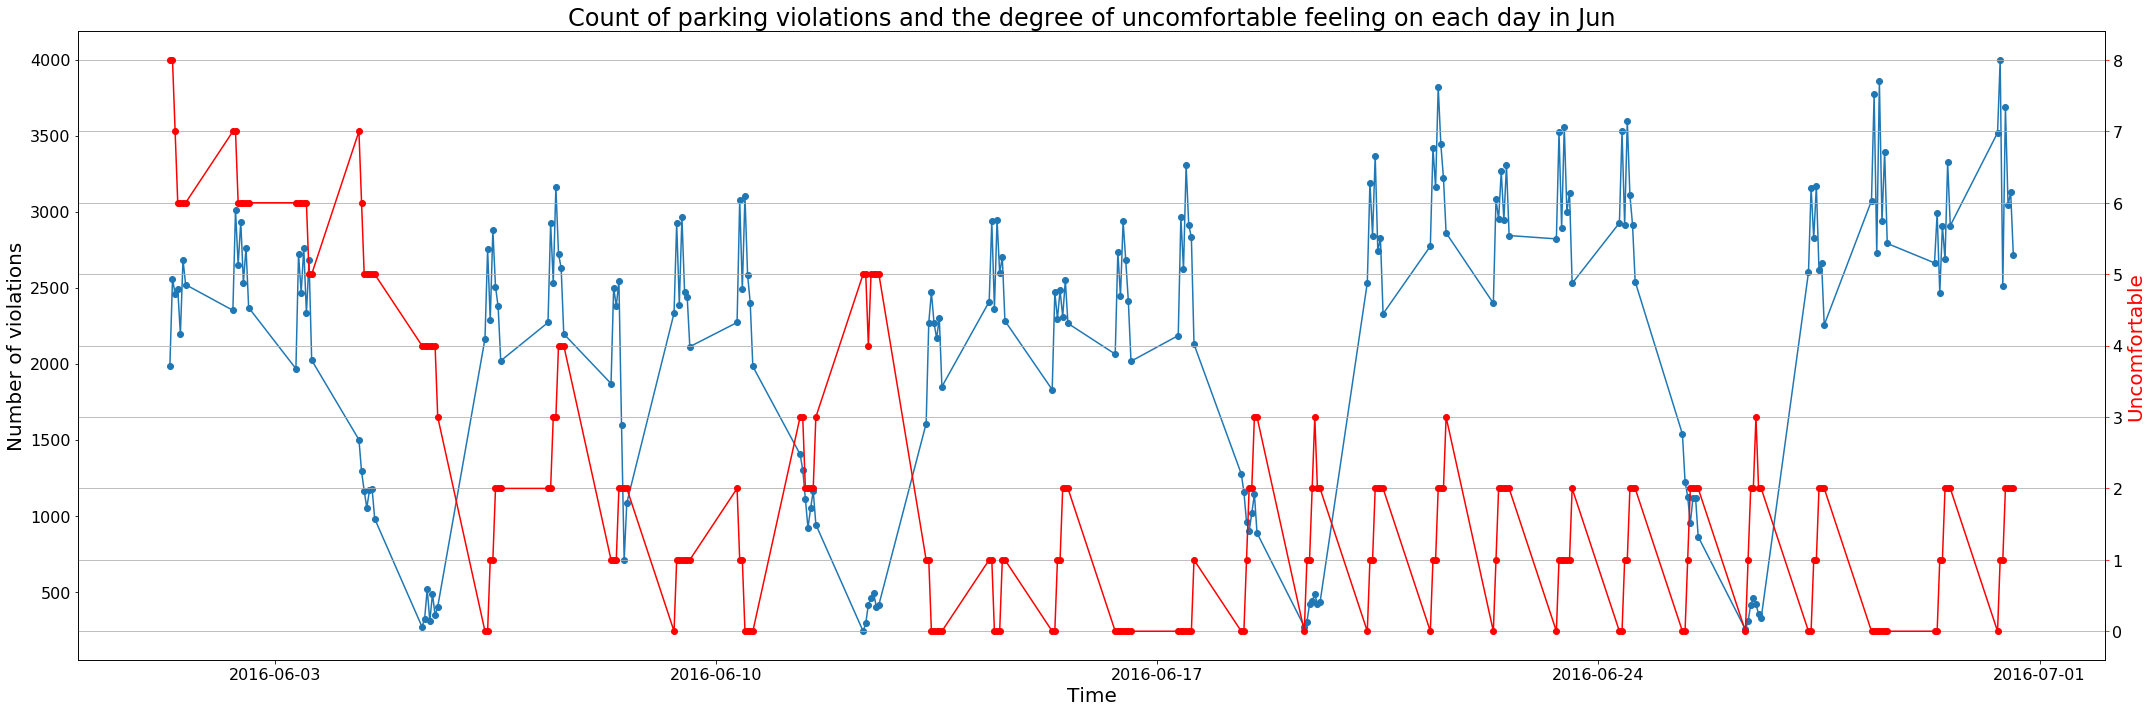

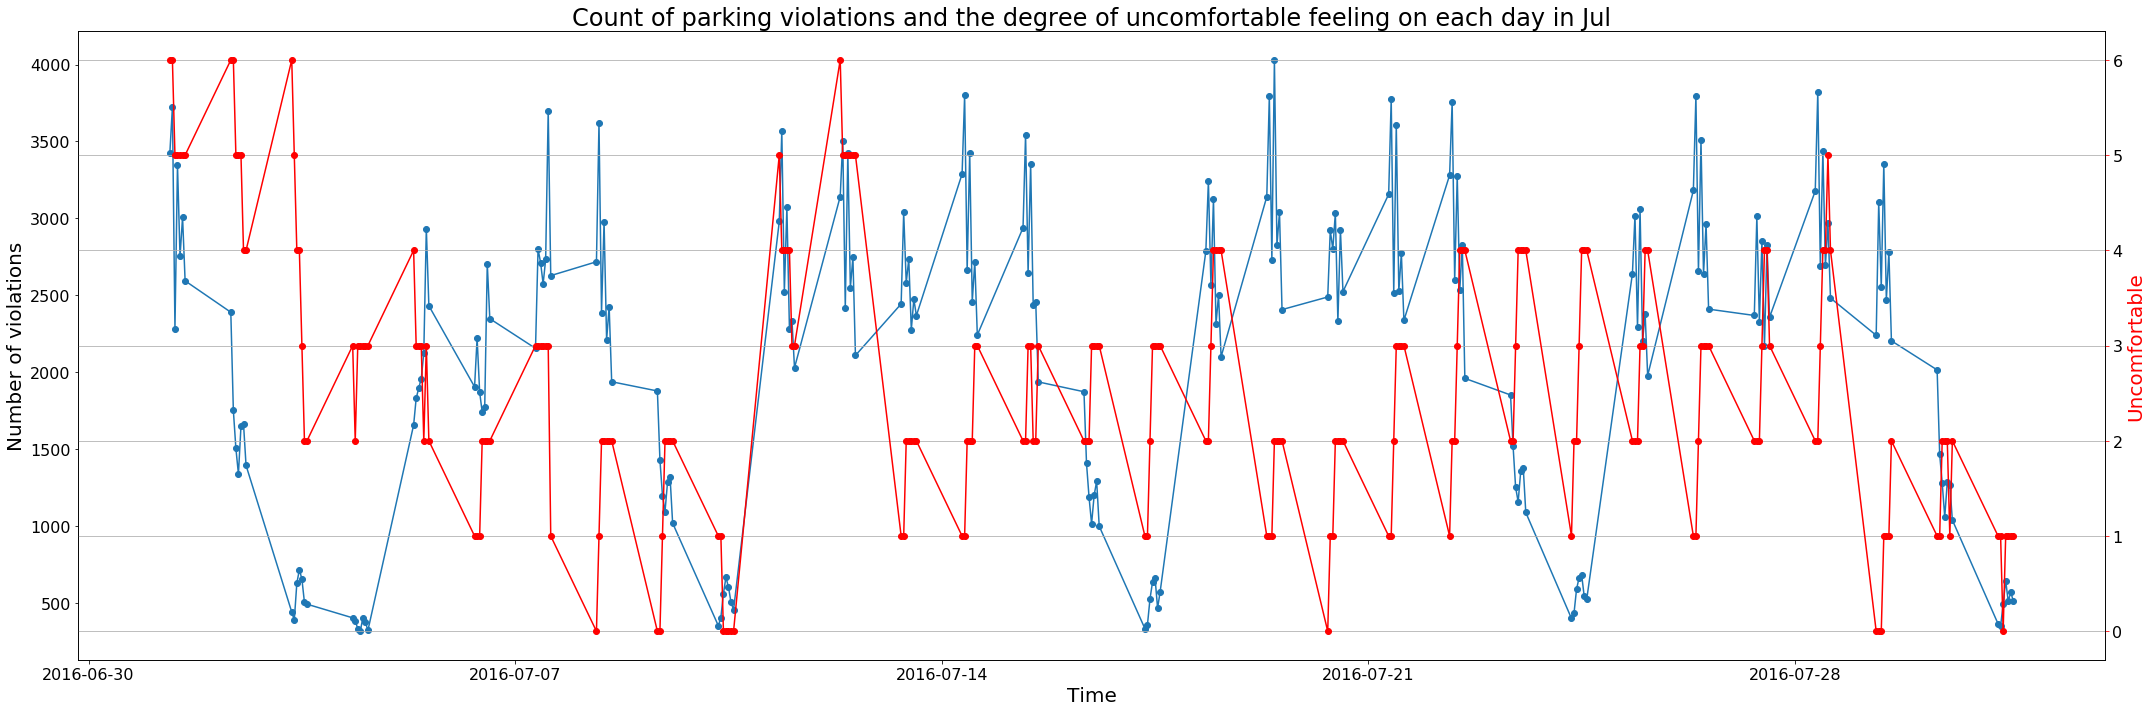

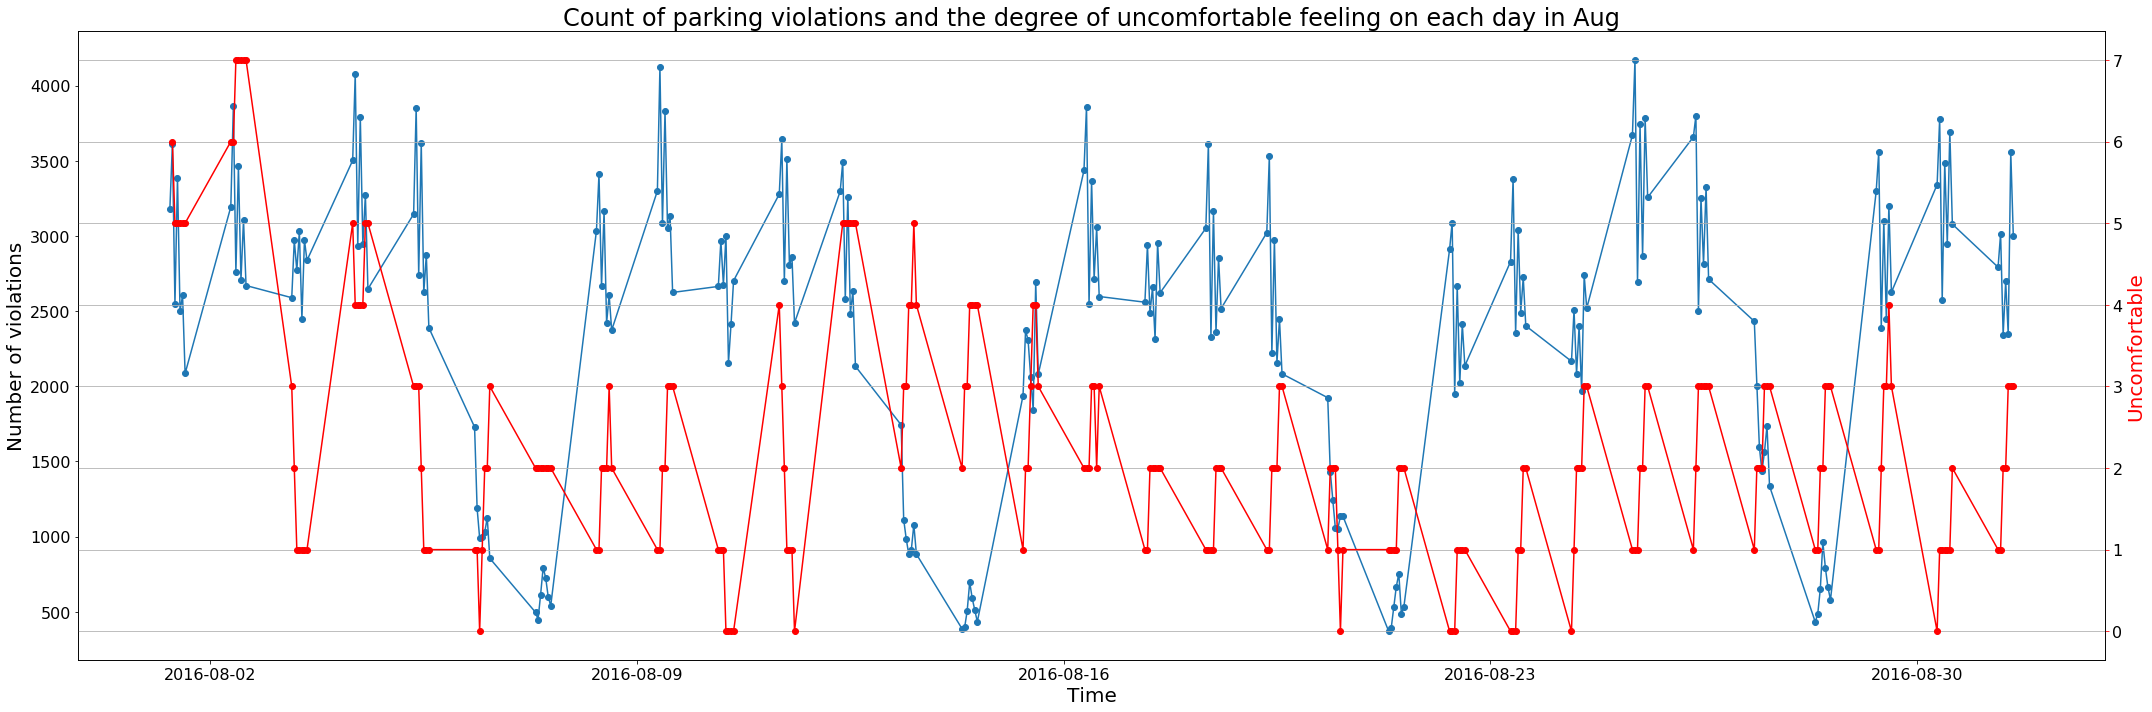

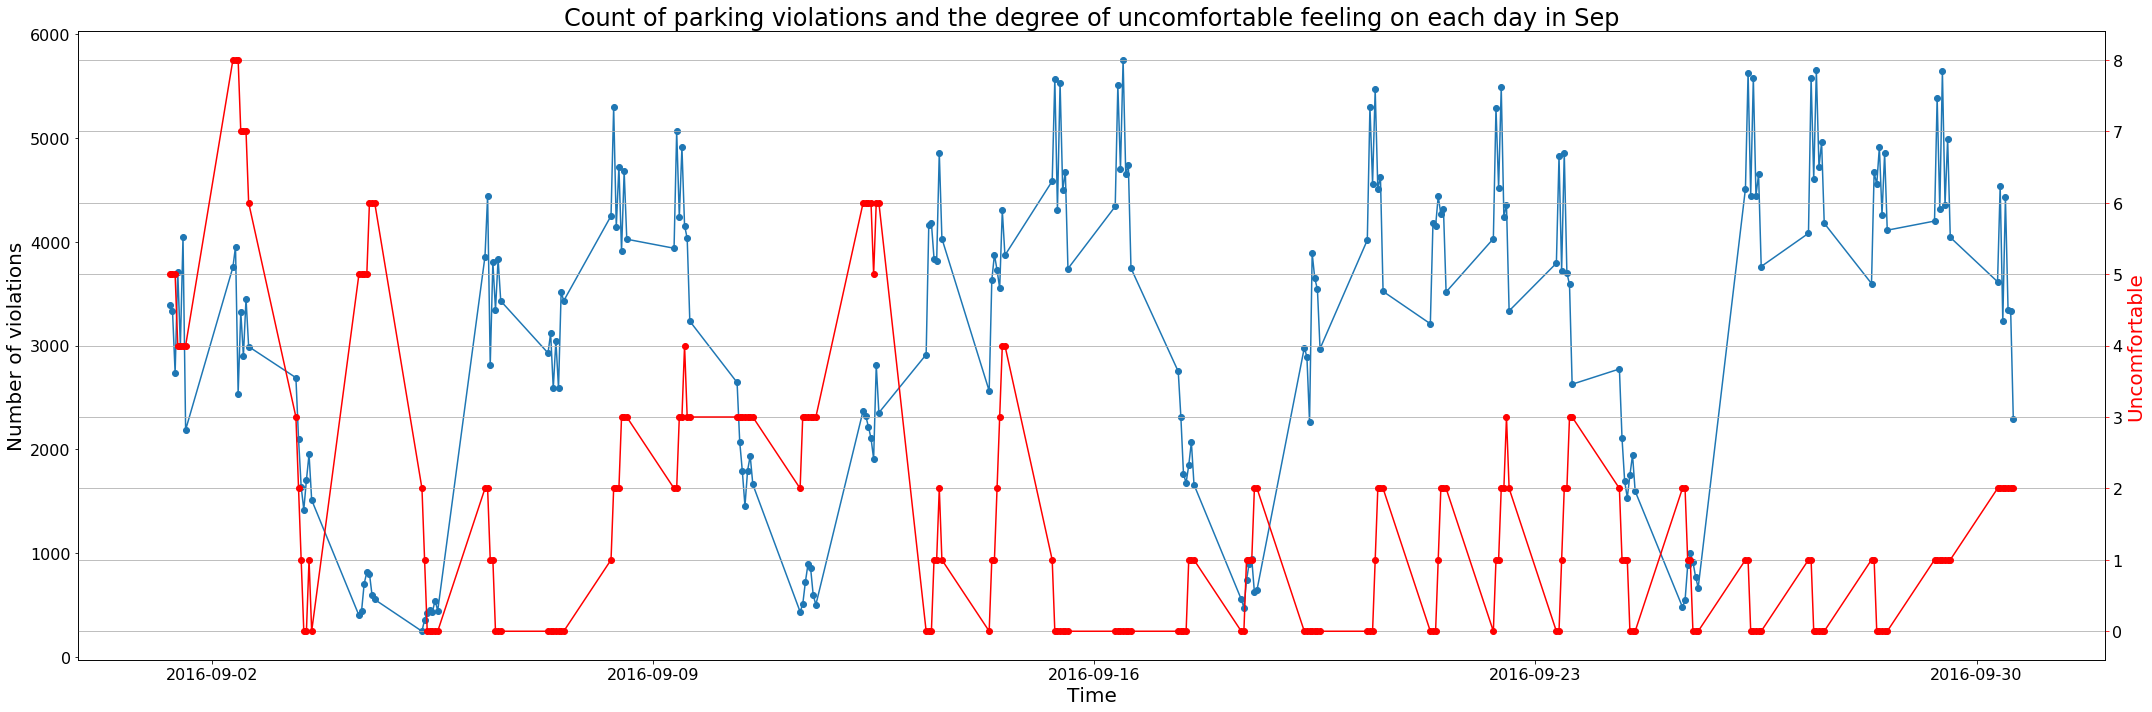

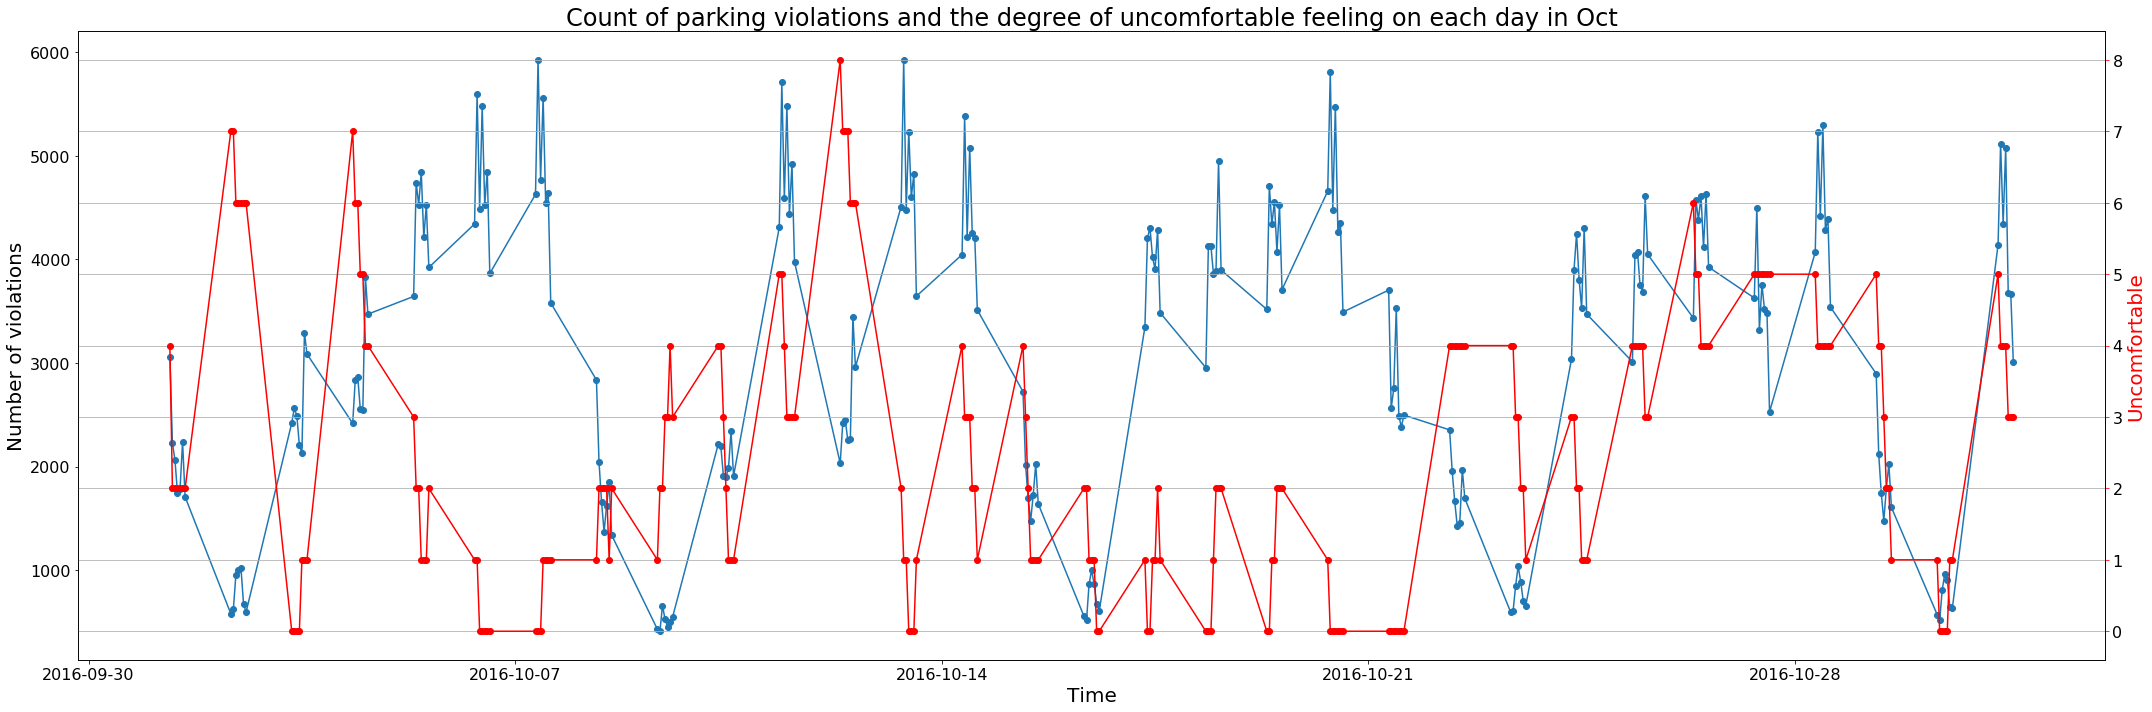

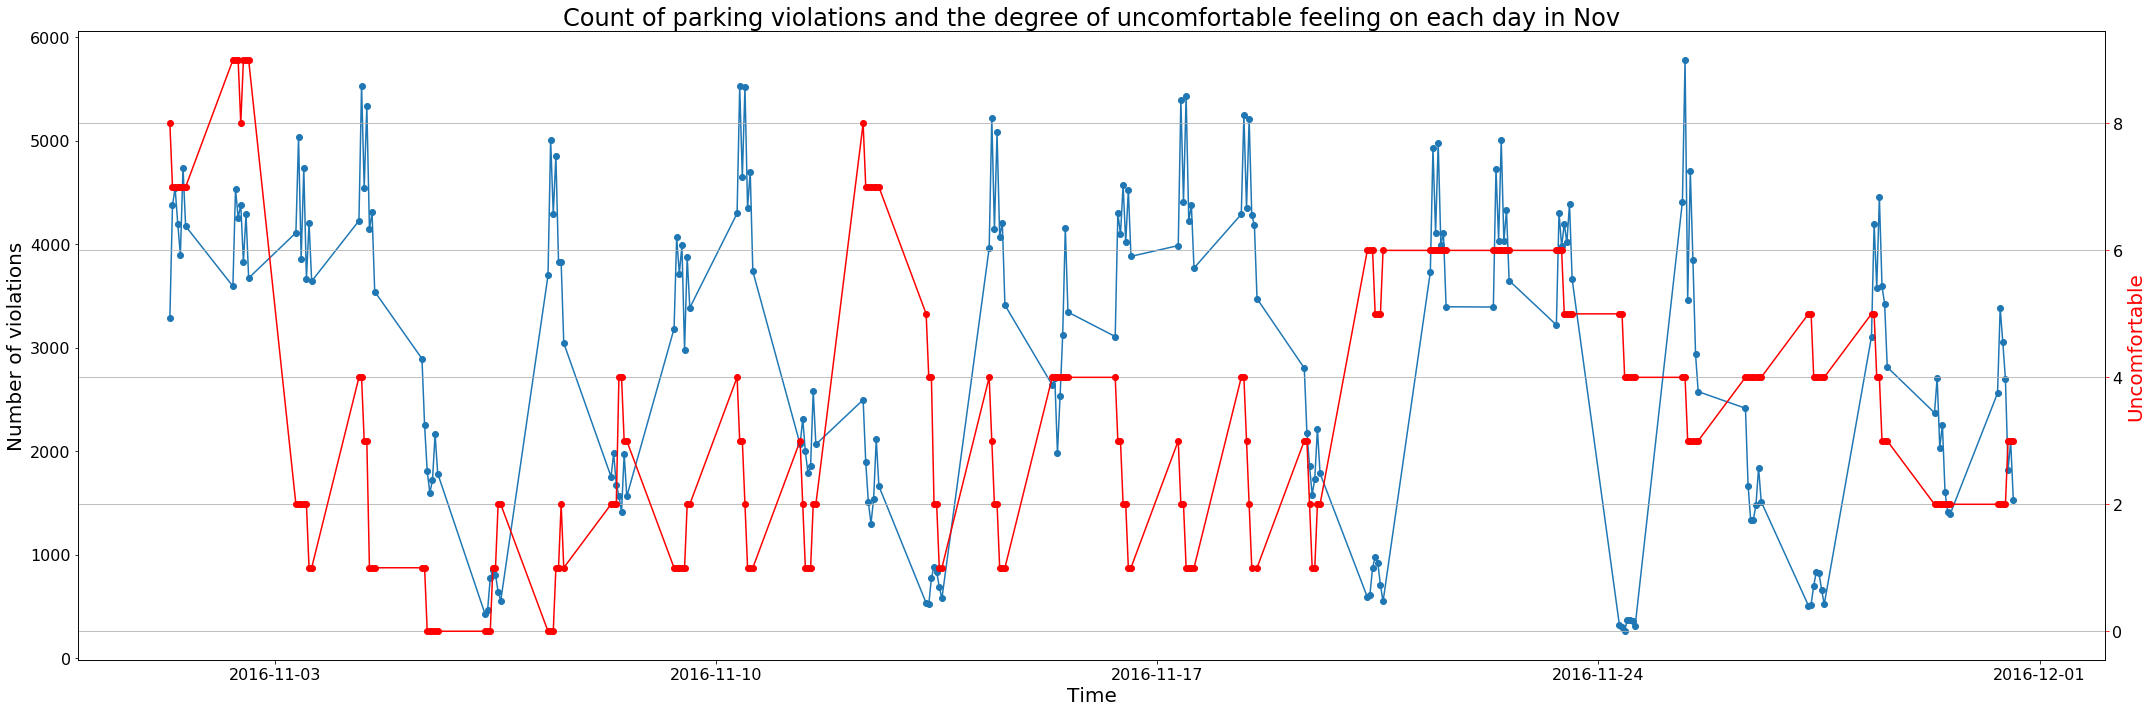

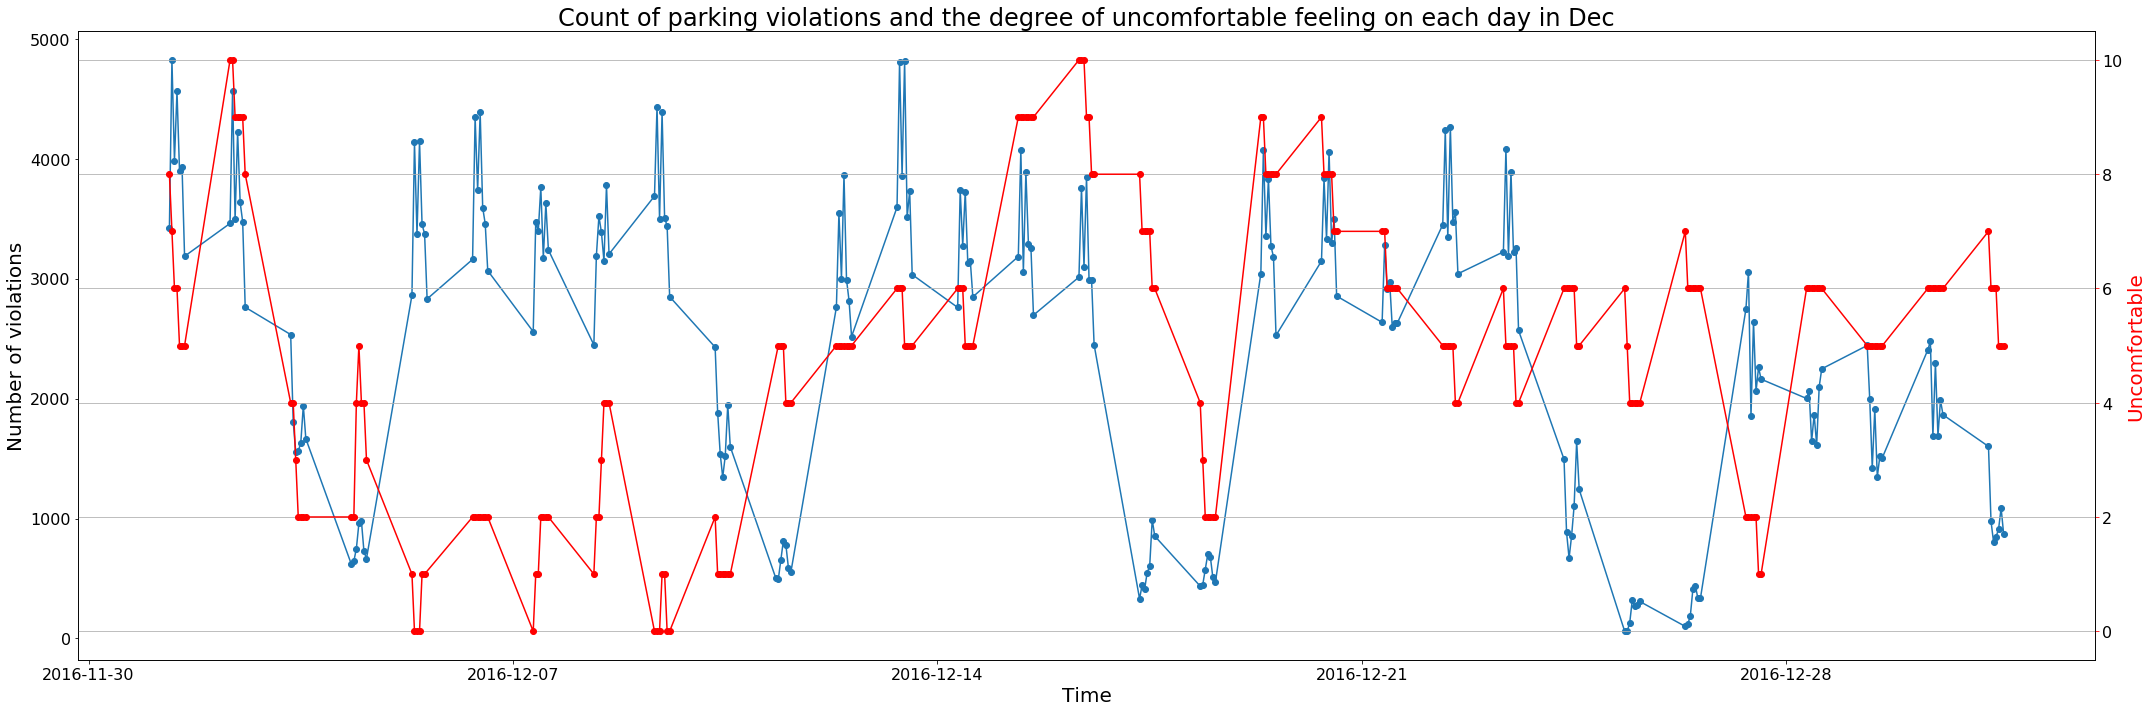

In [20]:
#Make a plot showing the number of violations and the degree of uncomfortable feeling on each hour
for month in monthList:
    hourList = []
    countList = []

    for time in sorted(violationMonthDict[month]):
        hour = (int)(time.strftime("%H"))
        if hour<8 or hour>14:
            continue
        hourList.append(time)
        countList.append(violationMonthDict[month][time])

    hourList2 = []
    uncomfortableList = []
    for time in sorted(tempMonthDict[month]):
        if tempMonthDict[month][time]['tempi'] == None:
            continue
        hour = (int)(time.strftime("%H"))
        if hour<8 or hour>14:
            continue
        hourList2.append(time)
        tempList.append(tempMonthDict[month][time]['tempi'])
        temperature = float(tempMonthDict[month][time]['tempi'])
        temperature = abs(temperature-70)
        uncomfortableList.append((int)(temperature/5))
               
        
    fig, ax1 = plt.subplots(figsize=(30,10))
    plt.title("Count of parking violations and the degree of uncomfortable feeling on each day in "+month, fontsize=24)

    ax1.plot(hourList, countList, 'o-')
    ax1.set_xlabel("Time", fontsize=20)
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel("Number of violations", fontsize=20)
    ax1.tick_params('y', labelsize=16)
    ax1.tick_params('x', labelsize=16)

    ax2 = ax1.twinx()
    ax2.plot(hourList2, uncomfortableList, 'o-', color='r')
    ax2.set_xlabel("Time", fontsize=20)
    ax2.set_ylabel("Uncomfortable", fontsize=20, color='r')
    ax2.tick_params('y', color='r', labelsize=16)


    fig.tight_layout()
    plt.grid()
    plt.show()

After looking at these figures, we can almost conclude that there is not obvious trend when the temperature is too high or too low.

### 6\. Answer if the number of parking violations is higher or lower when it is raining.

To do this, a boolean attribute of rain is used to find the hourly data where the boolean value is true.


In [21]:
#Classify violations and temperatures based on it was rainning or not

violationRainDict = {}

for time in hourlyweatherDict:
    if hourlyweatherDict[time]['rain'] == '1':
        violationRainDict[time] = violationTimeCount[time]
    else:
        violationRainDict[time] = None

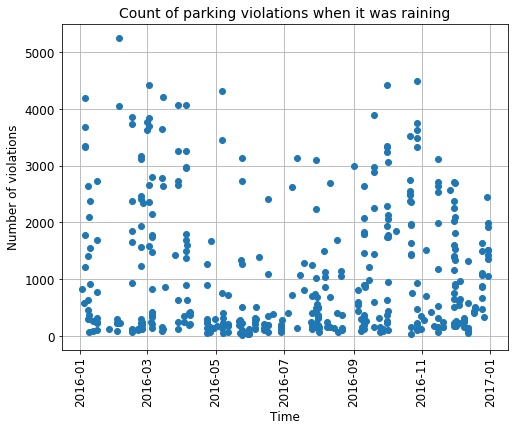

In [22]:
#Make a plot showing the number of violations when it was raining
timeList = []
rainList = []
for time in sorted(violationRainDict):
    timeList.append(time)
    rainList.append(violationRainDict[time])

plt.figure(figsize=(8,6))
plt.plot(timeList, rainList, 'o')
plt.title("Count of parking violations when it was raining", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Number of violations", fontsize=12)
plt.tick_params(labelsize=12)
plt.xticks(rotation=90)
plt.grid()
#plt.legend(fontsize=20)
#plt.savefig('all.png')
plt.show()    


This figure shows that the relation of raining and violation is not strong enough to be shown.

### 7\. Find the registration states with the largest numbers of parking violations.


In [23]:
#Store every registration state of parking violation vehicle to a list
violationStateList = []

for summons in violationWithoutMissingDict:
    violation = violationWithoutMissingDict[summons]
    violationStateList.append(violation['Registration State'])

#Make a plot showing the number of violations for every registration state
violationStateCount = Counter(violationStateList)
print("Registration State|Number of violation")
print("=======================================")
for state in violationStateCount.most_common(10):
    print(state[0]+' | '+"{:7d}".format(state[1]))

Registration State|Number of violation
NY | 7989407
NJ |  905010
PA |  258862
CT |  138979
FL |  138115
MA |   92847
IN |   75024
VA |   72536
MD |   59069
NC |   54113


This result shows that when the numbers of parking violations were calculated by the registration state of vehicles, Florida is the fifth. However, the distance between FL the farthest from NYC in these top ten states.